In [1]:
pip install numpy pandas pyquaternion scikit-learn seaborn xgboost

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pickle
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier

# --- AYARLAR ---
# Veri setinin bulunduğu ana klasör
BASE_DATASET_FOLDER = ""
# Analiz edilecek hareket
MOVEMENT_TO_ANALYZE = ""
# Analize dahil edilecek kullanıcılar
USERS_TO_ANALYZE = ["User-A","User-B", "User-E"]

# Grafiklerin daha güzel görünmesi için stil ayarı
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("talk") # Grafikleri daha okunaklı yapar
print("Kütüphaneler ve ayarlar hazır.")

Kütüphaneler ve ayarlar hazır.


In [3]:
# --- VERİ İŞLEME FONKSİYONLARI ---
def reshape_from_pkl(frames_list):
    """
    .pkl'den okunan 'düz' listeyi, her sensör için bir DataFrame
    içeren bir listeye dönüştürür.
    """
    num_sensors = 10
    all_sensor_data = []
    for frame in frames_list:
        frame_sensors = []
        if len(frame) == num_sensors * 4:
            for i in range(num_sensors):
                x, y, z, w = frame[i*4:i*4+4]
                frame_sensors.append({'w': w, 'x': x, 'y': y, 'z': z})
            all_sensor_data.append(frame_sensors)
    
    sensor_data_frames = []
    for i in range(num_sensors):
        sensor_i_timeseries = [frame[i] for frame in all_sensor_data]
        sensor_data_frames.append(pd.DataFrame(sensor_i_timeseries))
    return sensor_data_frames

def normalize_movement(movement_data_list, npose_data_list):
    """
    Bir hareket kaydını, verilen N-Pose referansına göre normalize eder.
    """
    if not movement_data_list or not npose_data_list: return None
    normalized_movement = []
    for i in range(len(movement_data_list)):
        q_ref_row = npose_data_list[i].iloc[0]
        q_ref = Quaternion(w=q_ref_row['w'], x=q_ref_row['x'], y=q_ref_row['y'], z=q_ref_row['z'])
        q_ref_inverse = q_ref.inverse
        
        normalized_frames = []
        for row in movement_data_list[i].itertuples():
            live_quat = Quaternion(w=row.w, x=row.x, y=row.y, z=row.z)
            normalized_quat = q_ref_inverse * live_quat
            normalized_frames.append({
                'w': normalized_quat.w, 'x': normalized_quat.x,
                'y': normalized_quat.y, 'z': normalized_quat.z
            })
            
        normalized_df = pd.DataFrame(normalized_frames)
        normalized_movement.append(normalized_df)
    return normalized_movement

# --- ANA VERİ YÜKLEME KODU ---
all_movements = []
print(f"'{MOVEMENT_TO_ANALYZE}' hareketi için veri yükleniyor...")

for user_id in USERS_TO_ANALYZE:
    user_path = os.path.join(BASE_DATASET_FOLDER, MOVEMENT_TO_ANALYZE, user_id)
    if not os.path.isdir(user_path):
        print(f"UYARI: {user_id} için klasör bulunamadı, atlanıyor.")
        continue
    
    # Her kullanıcı için N-Pose referansını bul
    npose_file = next((f for f in os.listdir(user_path) if f.startswith('npose_')), None)
    if not npose_file:
        print(f"UYARI: {user_id} için N-Pose referans dosyası bulunamadı, atlanıyor.")
        continue

    with open(os.path.join(user_path, npose_file), 'rb') as f:
        npose_reference = reshape_from_pkl(pickle.load(f)['data'])
    
    print(f"-> {user_id} için N-Pose referansı yüklendi.")

    # Kullanıcının tüm etiket klasörlerini tara
    for label_folder in os.listdir(user_path):
        label_path = os.path.join(user_path, label_folder)
        if not os.path.isdir(label_path): continue
        
        for movement_file in os.listdir(label_path):
            if not movement_file.startswith("movement_"): continue
            
            with open(os.path.join(label_path, movement_file), 'rb') as f:
                movement_dict = pickle.load(f)
            
            movement_raw = reshape_from_pkl(movement_dict['data'])
            movement_normalized = normalize_movement(movement_raw, npose_reference)
            
            all_movements.append({
                'data': movement_normalized,
                'label': label_folder, # Klasör adını etiket olarak kullanıyoruz
                'user': user_id
            })

print(f"\nİşlem tamamlandı. Toplam {len(all_movements)} hareket kaydı yüklendi ve normalize edildi.")

'' hareketi için veri yükleniyor...
-> User-A için N-Pose referansı yüklendi.
-> User-B için N-Pose referansı yüklendi.
-> User-E için N-Pose referansı yüklendi.

İşlem tamamlandı. Toplam 131 hareket kaydı yüklendi ve normalize edildi.


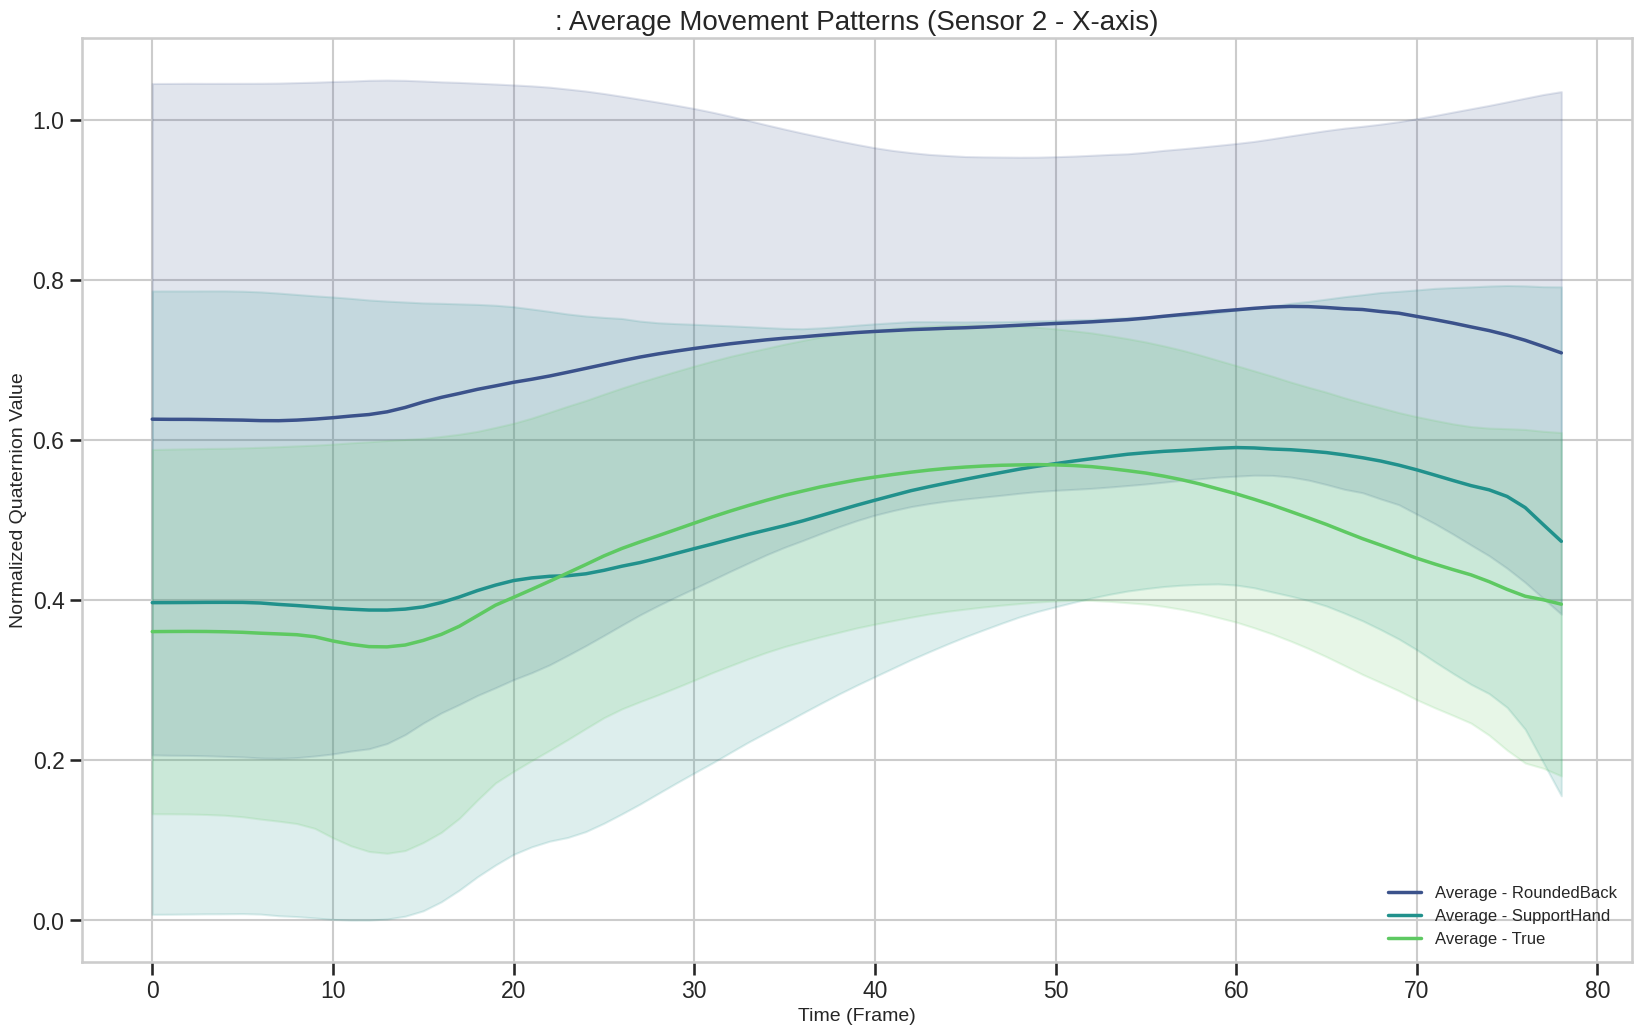

In [4]:
plt.figure(figsize=(20, 12))
ax = plt.gca()
labels = sorted(list(set(m['label'] for m in all_movements)))
colors = sns.color_palette("viridis", len(labels))

# Analiz için en ilgili sensörlerden biri (örneğin sağ üst kol, s2)
SENSOR_TO_PLOT = 1 # Index 1 = Sensor 2
COMPONENT_TO_PLOT = 'x' # x, y, z, w'den biri

for i, label in enumerate(labels):
    series = [m['data'][SENSOR_TO_PLOT][COMPONENT_TO_PLOT].values for m in all_movements if m['label'] == label]
    min_len = min(len(s) for s in series)
    series_padded = [s[:min_len] for s in series]
    mean_series = np.mean(series_padded, axis=0)
    std_series = np.std(series_padded, axis=0)
    
    ax.plot(mean_series, label=f'Average - {label}', color=colors[i], linewidth=2.5)
    ax.fill_between(range(min_len), mean_series - std_series, mean_series + std_series, color=colors[i], alpha=0.15)

ax.set_title(f'{MOVEMENT_TO_ANALYZE}: Average Movement Patterns (Sensor {SENSOR_TO_PLOT+1} - {COMPONENT_TO_PLOT.upper()}-axis)', fontsize=20)
ax.set_xlabel('Time (Frame)', fontsize=14)
ax.set_ylabel('Normalized Quaternion Value', fontsize=14)
ax.legend(fontsize=12)
plt.show()

In [5]:
def get_statistical_features(timeseries):
    return {'mean': np.mean(timeseries), 'std': np.std(timeseries), 'min': np.min(timeseries), 'max': np.max(timeseries), 'range': np.max(timeseries) - np.min(timeseries)}

def get_quaternion_features(quat_df, prefix):
    features = {}
    for component in ['w', 'x', 'y', 'z']:
        stats = get_statistical_features(quat_df[component])
        for stat_name, value in stats.items(): features[f'{prefix}_{component}_{stat_name}'] = value
    return features

def calculate_relative_quaternions(df1, df2):
    relative_frames = []
    for i in range(len(df1)):
        q1 = Quaternion(w=df1.iloc[i]['w'], x=df1.iloc[i]['x'], y=df1.iloc[i]['y'], z=df1.iloc[i]['z'])
        q2 = Quaternion(w=df2.iloc[i]['w'], x=df2.iloc[i]['x'], y=df2.iloc[i]['y'], z=df2.iloc[i]['z'])
        relative_q = q2.inverse * q1
        relative_frames.append({'w': relative_q.w, 'x': relative_q.x, 'y': relative_q.y, 'z': relative_q.z})
    return pd.DataFrame(relative_frames)

def extract_features_for_movement(normalized_data):
    all_features = {}
    for i, sensor_df in enumerate(normalized_data): all_features.update(get_quaternion_features(sensor_df, f's{i+1}'))
    all_features.update(get_quaternion_features(calculate_relative_quaternions(normalized_data[1], normalized_data[4]), 'rel_s2_s5'))
    all_features.update(get_quaternion_features(calculate_relative_quaternions(normalized_data[0], normalized_data[1]), 'rel_s1_s2'))
    all_features.update(get_quaternion_features(calculate_relative_quaternions(normalized_data[2], normalized_data[7]), 'rel_s3_s8'))
    return all_features

print("Özellik çıkarımı başlıyor...")
feature_list = []
for movement in all_movements:
    features = extract_features_for_movement(movement['data'])
    features['label'] = movement['label']
    features['user'] = movement['user']
    feature_list.append(features)

features_df = pd.DataFrame(feature_list)
print(f"Özellik çıkarımı tamamlandı. {features_df.shape[0]} kayıt için toplam {features_df.shape[1]-2} özellik oluşturuldu.")
features_df.head()

Özellik çıkarımı başlıyor...
Özellik çıkarımı tamamlandı. 131 kayıt için toplam 260 özellik oluşturuldu.


,s1_w_mean,s1_w_std,s1_w_min,s1_w_max,s1_w_range,s1_x_mean,s1_x_std,s1_x_min,s1_x_max,s1_x_range,...,rel_s3_s8_y_min,rel_s3_s8_y_max,rel_s3_s8_y_range,rel_s3_s8_z_mean,rel_s3_s8_z_std,rel_s3_s8_z_min,rel_s3_s8_z_max,rel_s3_s8_z_range,label,user
0,0.854077,0.011623,0.834315,0.869845,0.035529,0.439099,0.018935,0.398764,0.462552,0.063788,...,-0.056126,0.300184,0.356311,-0.351343,0.154573,-0.571105,-0.134918,0.436187,True,User-A
1,0.854914,0.003859,0.849429,0.864734,0.015305,0.448054,0.029021,0.408389,0.493298,0.084908,...,-0.114299,0.241910,0.356210,-0.296183,0.147589,-0.512996,-0.106542,0.406454,True,User-A
2,0.857419,0.004189,0.849200,0.864686,0.015487,0.452710,0.025306,0.419628,0.494607,0.074979,...,-0.131122,0.155466,0.286588,-0.211095,0.144084,-0.404709,-0.015066,0.389644,True,User-A
3,0.841794,0.005249,0.830262,0.850478,0.020216,0.459859,0.022829,0.427088,0.493272,0.066184,...,-0.086772,0.270275,0.357047,-0.318602,0.154302,-0.550478,-0.107350,0.443128,True,User-A
4,0.858992,0.006926,0.846182,0.871452,0.025271,0.439339,0.028335,0.402899,0.485404,0.082505,...,-0.115162,0.010186,0.125348,-0.027347,0.144029,-0.233460,0.165969,0.399430,True,User-A


PCA - Açıklanan Varyans Oranı: 59.68%
t-SNE analizi başlıyor (biraz sürebilir)...
t-SNE analizi tamamlandı.


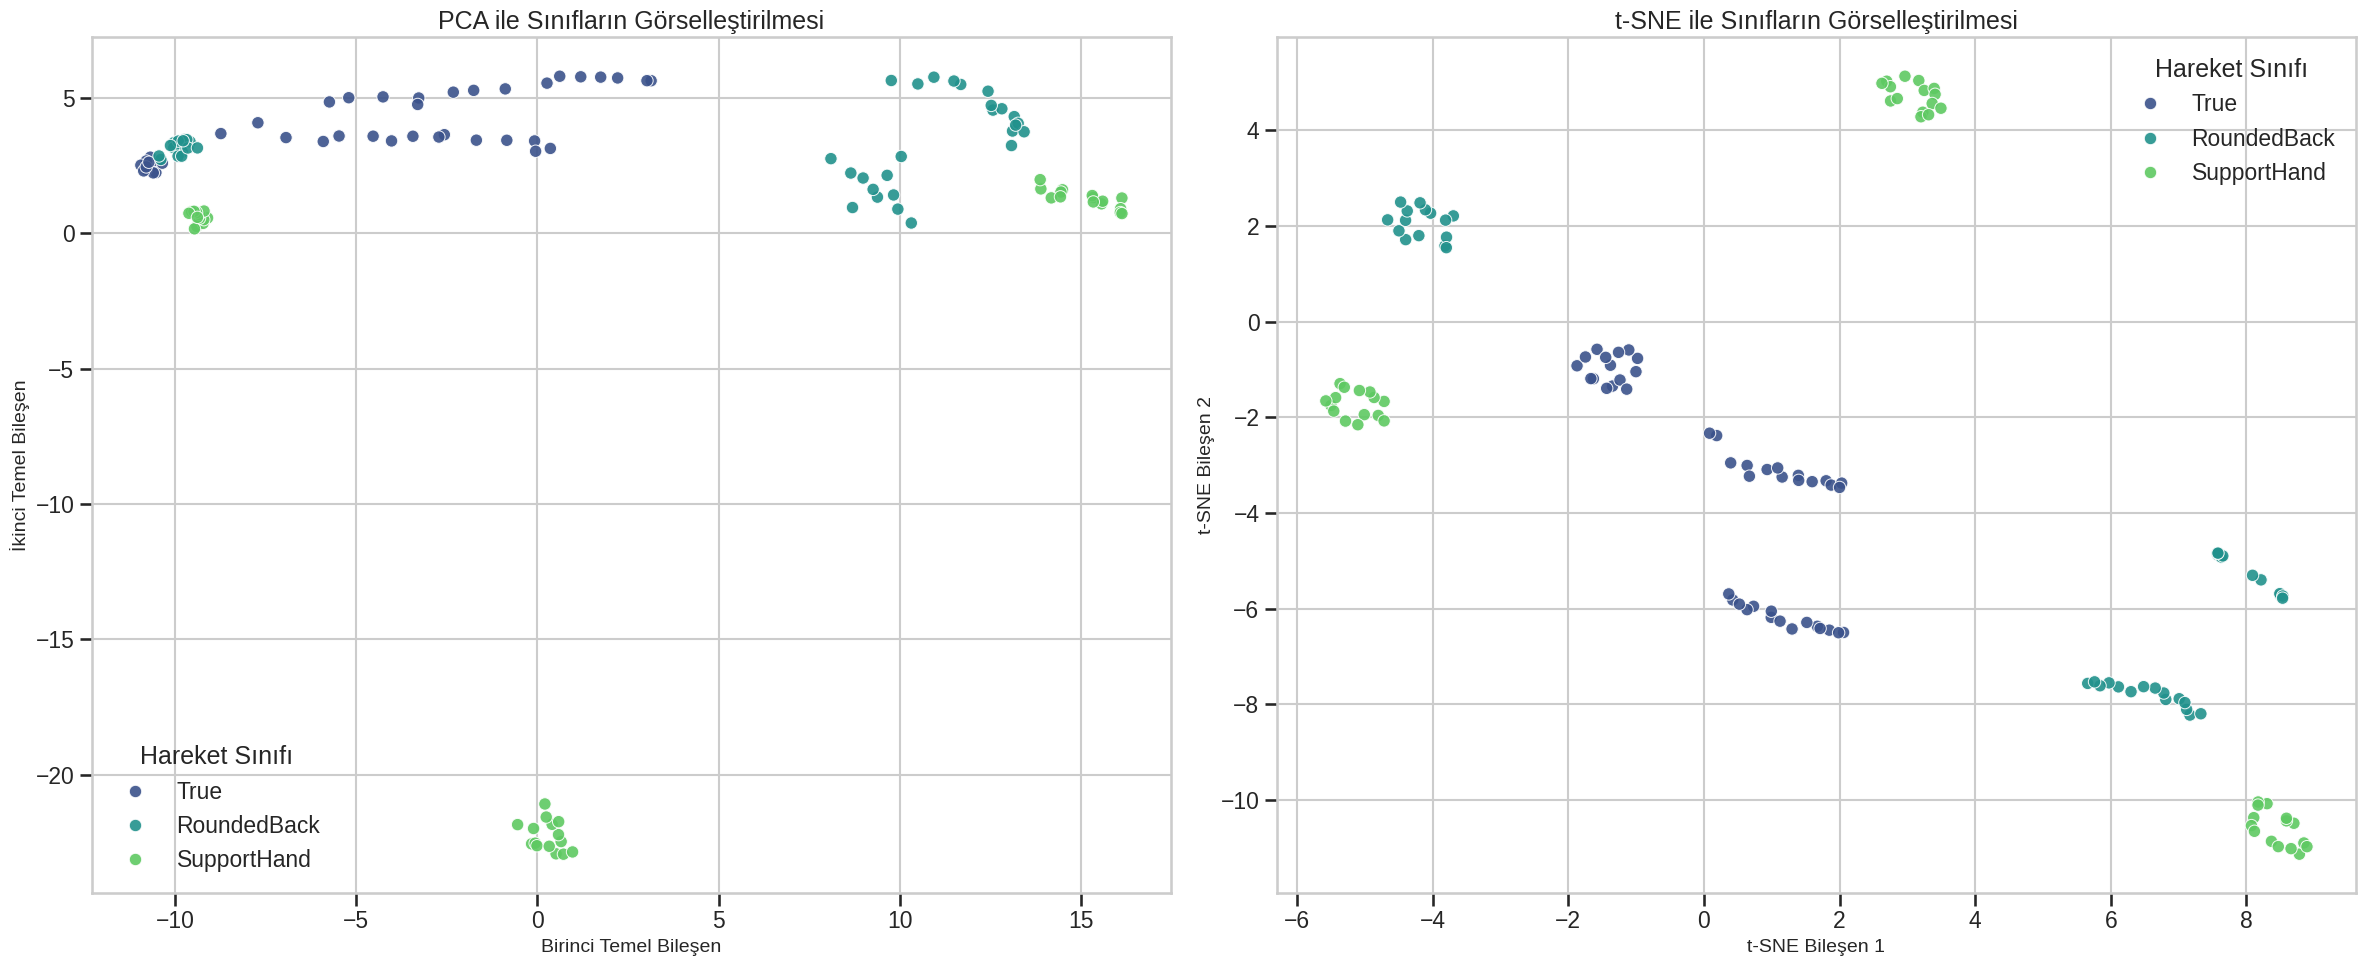

In [6]:
# Özellikleri (X) ve etiketleri (y) ayır
X = features_df.drop(['label', 'user'], axis=1)
y = features_df['label']

# Özellikleri ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PCA Analizi ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA - Açıklanan Varyans Oranı: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# --- t-SNE Analizi ---
print("t-SNE analizi başlıyor (biraz sürebilir)...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
print("t-SNE analizi tamamlandı.")


# Sonuçları tek bir figürde yan yana göster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# PCA Grafiği
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', s=80, alpha=0.9, ax=ax1)
ax1.set_title('PCA ile Sınıfların Görselleştirilmesi', fontsize=18)
ax1.set_xlabel('Birinci Temel Bileşen', fontsize=14)
ax1.set_ylabel('İkinci Temel Bileşen', fontsize=14)
ax1.legend(title='Hareket Sınıfı')
ax1.grid(True)

# t-SNE Grafiği
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', s=80, alpha=0.9, ax=ax2)
ax2.set_title('t-SNE ile Sınıfların Görselleştirilmesi', fontsize=18)
ax2.set_xlabel('t-SNE Bileşen 1', fontsize=14)
ax2.set_ylabel('t-SNE Bileşen 2', fontsize=14)
ax2.legend(title='Hareket Sınıfı')
ax2.grid(True)

plt.tight_layout()
plt.show()

--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---

=> Test Kullanıcısı: User-A
  - Random Forest: Accuracy = 0.8222, F1-Score = 0.8086
  - SVM: Accuracy = 0.4000, F1-Score = 0.2865
  - XGBoost: Accuracy = 0.6889, F1-Score = 0.6023
  - Logistic Regression: Accuracy = 0.7333, F1-Score = 0.6825

=> Test Kullanıcısı: User-B


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:40:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Random Forest: Accuracy = 0.3333, F1-Score = 0.1667
  - SVM: Accuracy = 0.3333, F1-Score = 0.1667
  - XGBoost: Accuracy = 0.3333, F1-Score = 0.2041
  - Logistic Regression: Accuracy = 0.3333, F1-Score = 0.1667

=> Test Kullanıcısı: User-E


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:40:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Random Forest: Accuracy = 1.0000, F1-Score = 1.0000
  - SVM: Accuracy = 0.6341, F1-Score = 0.5254
  - XGBoost: Accuracy = 0.7561, F1-Score = 0.7332
  - Logistic Regression: Accuracy = 1.0000, F1-Score = 1.0000

--- Ortalama Performans Sonuçları ---
                 Model  Average Accuracy  Average F1-Score
0        Random Forest          0.718519          0.658426
3  Logistic Regression          0.688889          0.616402
2              XGBoost          0.592773          0.513195
1                  SVM          0.455827          0.326198


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:40:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipykernel_149/3381573698.py:73: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Accuracy', y='Model', data=summary_df, palette='viridis')


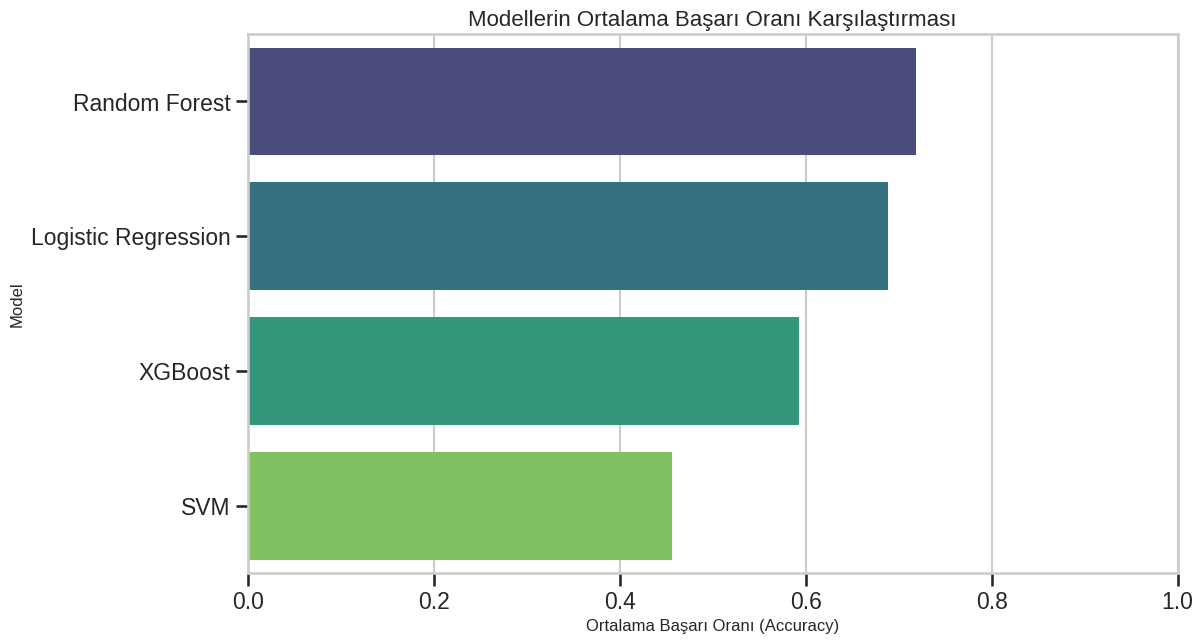


En iyi model 'Random Forest' olarak belirlendi.
Bu model şimdi TÜM veri setiyle son bir kez eğitilip kaydediliyor...

--- İşlem Tamamlandı! ---
En iyi model ve diğer bileşenler (scaler, label encoder) başarıyla kaydedildi.


In [7]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Farklı ML Modelleri
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

# --- Veriyi Hazırlama ---
# Bir önceki hücrede oluşturduğumuz features_df'i kullanıyoruz
X = features_df.drop(['label', 'user'], axis=1)
y_str = features_df['label']
groups = features_df['user'] # Kullanıcı bazlı ayırma için

# Etiketleri metinden sayılara dönüştür
le = LabelEncoder()
y = le.fit_transform(y_str)

# --- Model ve Değerlendirme Süreci ---
# Modelleri bir sözlükte tanımlayalım
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Her modelin performansını saklamak için bir yapı oluşturalım
results = {name: [] for name in models.keys()}
logo = LeaveOneGroupOut()

print("--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---")

# Her bir kullanıcıyı test seti olarak ayırarak döngüyü başlat
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_user = groups.iloc[test_idx].unique()[0]
    
    print(f"\n=> Test Kullanıcısı: {test_user}")

    # Veriyi ölçeklendir
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Her bir modeli eğit ve test et
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results[name].append({'accuracy': accuracy, 'f1_score': f1})
        print(f"  - {name}: Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}")

# --- Sonuçları Özetleme ---
print("\n--- Ortalama Performans Sonuçları ---")
summary = []
for name, scores in results.items():
    avg_accuracy = np.mean([s['accuracy'] for s in scores])
    avg_f1 = np.mean([s['f1_score'] for s in scores])
    summary.append({'Model': name, 'Average Accuracy': avg_accuracy, 'Average F1-Score': avg_f1})

summary_df = pd.DataFrame(summary).sort_values('Average F1-Score', ascending=False)
print(summary_df)

# --- Sonuçları Görselleştirme ---
plt.figure(figsize=(12, 7))
sns.barplot(x='Average Accuracy', y='Model', data=summary_df, palette='viridis')
plt.title('Modellerin Ortalama Başarı Oranı Karşılaştırması', fontsize=16)
plt.xlabel('Ortalama Başarı Oranı (Accuracy)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.0)
plt.show()


# --- En İyi Modeli Seçme ve Kaydetme ---
best_model_name = summary_df.iloc[0]['Model']
print(f"\nEn iyi model '{best_model_name}' olarak belirlendi.")
print("Bu model şimdi TÜM veri setiyle son bir kez eğitilip kaydediliyor...")

# Final modelini tüm veriyle eğit
final_scaler = StandardScaler().fit(X)
X_scaled_final = final_scaler.transform(X)

final_model = models[best_model_name]
final_model.fit(X_scaled_final, y)

# Modeli ve gerekli bileşenleri kaydet
pickle.dump(final_model, open("final_model.pkl", "wb"))
pickle.dump(final_scaler, open("final_scaler.pkl", "wb"))
pickle.dump(le, open("final_label_encoder.pkl", "wb"))

print("\n--- İşlem Tamamlandı! ---")
print("En iyi model ve diğer bileşenler (scaler, label encoder) başarıyla kaydedildi.")

--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---

=> Test Kullanıcısı: User-A
  - Random Forest: Accuracy = 0.8222, F1-Score = 0.8086
  - SVM: Accuracy = 0.4000, F1-Score = 0.2865


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:40:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - XGBoost: Accuracy = 0.6889, F1-Score = 0.6023
  - KNN: Accuracy = 0.6667, F1-Score = 0.5556
  - Logistic Regression: Accuracy = 0.7333, F1-Score = 0.6825

=> Test Kullanıcısı: User-B
  - Random Forest: Accuracy = 0.3333, F1-Score = 0.1667
  - SVM: Accuracy = 0.3333, F1-Score = 0.1667
  - XGBoost: Accuracy = 0.3333, F1-Score = 0.2041
  - KNN: Accuracy = 0.3333, F1-Score = 0.1667
  - Logistic Regression: Accuracy = 0.3333, F1-Score = 0.1667

=> Test Kullanıcısı: User-E


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:40:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


  - Random Forest: Accuracy = 1.0000, F1-Score = 1.0000
  - SVM: Accuracy = 0.6341, F1-Score = 0.5254
  - XGBoost: Accuracy = 0.7561, F1-Score = 0.7332
  - KNN: Accuracy = 1.0000, F1-Score = 1.0000
  - Logistic Regression: Accuracy = 1.0000, F1-Score = 1.0000

--- Ortalama Performans Sonuçları ---
                 Model  Average Accuracy  Average F1-Score
0        Random Forest          0.718519          0.658426
4  Logistic Regression          0.688889          0.616402
3                  KNN          0.666667          0.574074
2              XGBoost          0.592773          0.513195
1                  SVM          0.455827          0.326198


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:40:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/tmp/ipykernel_149/3573633888.py:75: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Average Accuracy', y='Model', data=summary_df, palette='viridis')


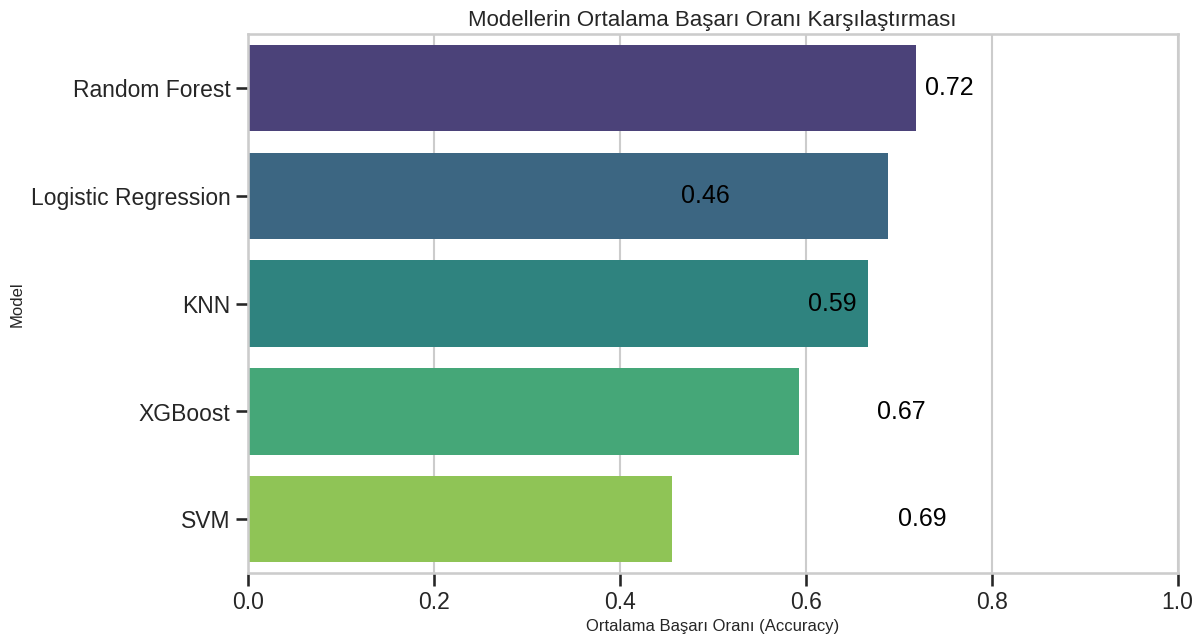


En iyi model 'Random Forest' olarak belirlendi.
Bu model şimdi TÜM veri setiyle son bir kez eğitilip kaydediliyor...

--- İşlem Tamamlandı! ---
En iyi model ve diğer bileşenler (scaler, label encoder) başarıyla kaydedildi.


In [8]:
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Farklı ML Modelleri
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier # YENİ: KNN eklendi
from xgboost import XGBClassifier

# --- Veriyi Hazırlama ---
# Bir önceki hücrede oluşturduğumuz features_df'i kullanıyoruz
X = features_df.drop(['label', 'user'], axis=1)
y_str = features_df['label']
groups = features_df['user'] # Kullanıcı bazlı ayırma için

# Etiketleri metinden sayılara dönüştür
le = LabelEncoder()
y = le.fit_transform(y_str)

# --- Model ve Değerlendirme Süreci ---
# Modelleri bir sözlükte tanımlayalım
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5), # YENİ: KNN modeli eklendi (5 komşu ile)
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

# Her modelin performansını saklamak için bir yapı oluşturalım
results = {name: [] for name in models.keys()}
logo = LeaveOneGroupOut()

print("--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---")

# Her bir kullanıcıyı test seti olarak ayırarak döngüyü başlat
for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_user = groups.iloc[test_idx].unique()[0]
    
    print(f"\n=> Test Kullanıcısı: {test_user}")

    # Veriyi ölçeklendir
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Her bir modeli eğit ve test et
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        
        results[name].append({'accuracy': accuracy, 'f1_score': f1})
        print(f"  - {name}: Accuracy = {accuracy:.4f}, F1-Score = {f1:.4f}")

# --- Sonuçları Özetleme ---
print("\n--- Ortalama Performans Sonuçları ---")
summary = []
for name, scores in results.items():
    avg_accuracy = np.mean([s['accuracy'] for s in scores])
    avg_f1 = np.mean([s['f1_score'] for s in scores])
    summary.append({'Model': name, 'Average Accuracy': avg_accuracy, 'Average F1-Score': avg_f1})

summary_df = pd.DataFrame(summary).sort_values('Average F1-Score', ascending=False)
print(summary_df)

# --- Sonuçları Görselleştirme ---
plt.figure(figsize=(12, 7))
sns.barplot(x='Average Accuracy', y='Model', data=summary_df, palette='viridis')
plt.title('Modellerin Ortalama Başarı Oranı Karşılaştırması', fontsize=16)
plt.xlabel('Ortalama Başarı Oranı (Accuracy)', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.xlim(0, 1.0)
for index, row in summary_df.iterrows():
    plt.text(row['Average Accuracy'] + 0.01, index, f"{row['Average Accuracy']:.2f}", color='black', ha="left", va='center')
plt.show()


# --- En İyi Modeli Seçme ve Kaydetme ---
best_model_name = summary_df.iloc[0]['Model']
print(f"\nEn iyi model '{best_model_name}' olarak belirlendi.")
print("Bu model şimdi TÜM veri setiyle son bir kez eğitilip kaydediliyor...")

# Final modelini tüm veriyle eğit
final_scaler = StandardScaler().fit(X)
X_scaled_final = final_scaler.transform(X)

# En iyi modelin yeni bir örneğini oluştur ve eğit
final_model = models[best_model_name] 
final_model.fit(X_scaled_final, y)

# Modeli ve gerekli bileşenleri kaydet
pickle.dump(final_model, open("final_model.pkl", "wb"))
pickle.dump(final_scaler, open("final_scaler.pkl", "wb"))
pickle.dump(le, open("final_label_encoder.pkl", "wb"))

print("\n--- İşlem Tamamlandı! ---")
print("En iyi model ve diğer bileşenler (scaler, label encoder) başarıyla kaydedildi.")

--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---

=> Test Kullanıcısı: User-A


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:03:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=> Test Kullanıcısı: User-B


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:03:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



=> Test Kullanıcısı: User-E


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [22:03:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- Ortalama Performans Sonuçları ---
                 Model  Average Accuracy  Average F1-Score
0        Random Forest          0.718519          0.658426
4  Logistic Regression          0.688889          0.616402
3                  KNN          0.666667          0.574074
2              XGBoost          0.592773          0.513195
1                  SVM          0.455827          0.326198

--- En İyi Model için Detaylı Analiz: Random Forest ---
✅ Karmaşıklık Matrisi kaydedildi: confusion_matrix_User-A.png
✅ Karmaşıklık Matrisi kaydedildi: confusion_matrix_User-B.png
✅ Karmaşıklık Matrisi kaydedildi: confusion_matrix_User-E.png


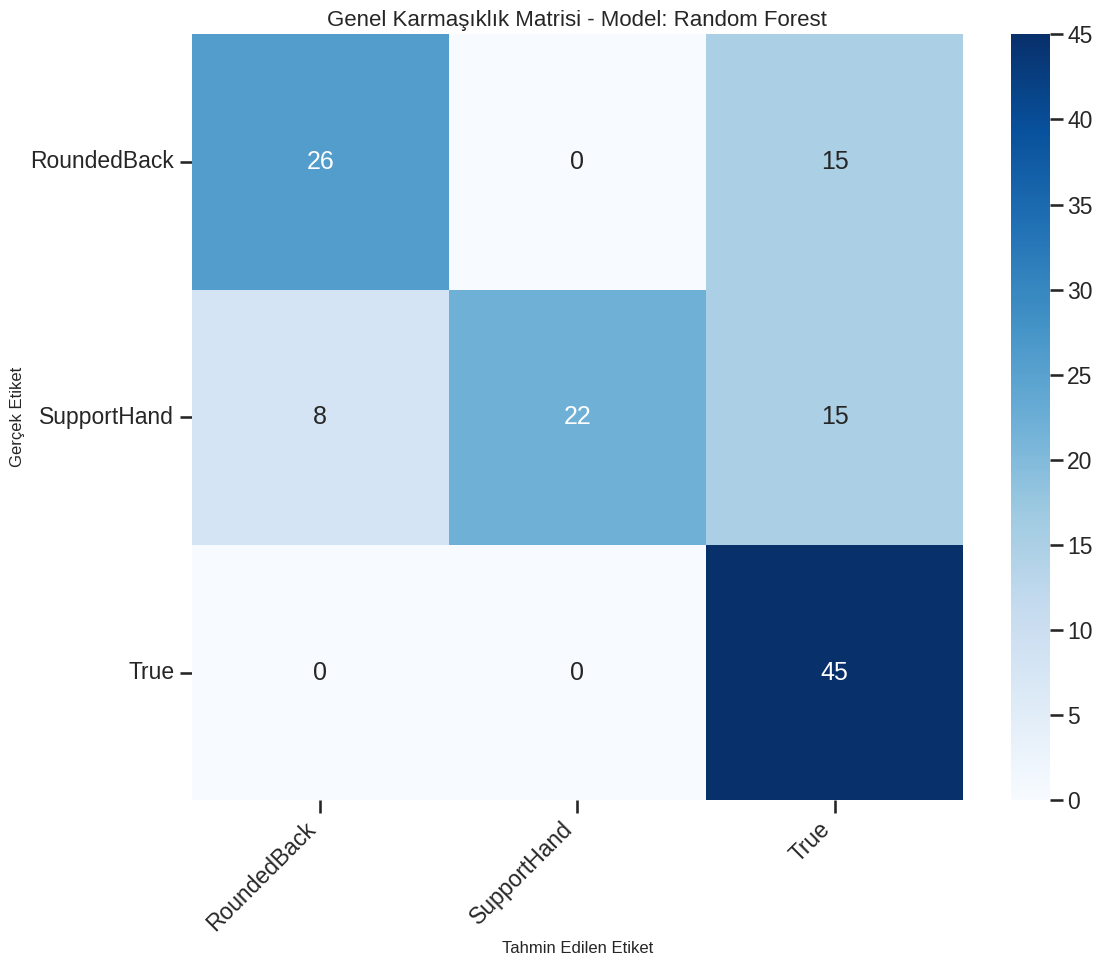

✅ Genel Karmaşıklık Matrisi kaydedildi: confusion_matrix_OVERALL.png

Genel Sınıflandırma Raporu:
              precision    recall  f1-score   support

 RoundedBack       0.76      0.63      0.69        41
 SupportHand       1.00      0.49      0.66        45
        True       0.60      1.00      0.75        45

    accuracy                           0.71       131
   macro avg       0.79      0.71      0.70       131
weighted avg       0.79      0.71      0.70       131


En iyi model 'Random Forest' tüm veriyle son kez eğitilip kaydediliyor...
Final modeli ve bileşenleri başarıyla kaydedildi.


In [10]:
import pandas as pd
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Farklı ML Modelleri
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

# --- Veriyi Hazırlama ---
# Bir önceki hücrede oluşturduğumuz features_df'i kullanıyoruz
X = features_df.drop(['label', 'user'], axis=1)
y_str = features_df['label']
groups = features_df['user']

le = LabelEncoder()
y = le.fit_transform(y_str)

# --- Model ve Değerlendirme Süreci ---
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42)
}

results = {name: [] for name in models.keys()}
# YENİ: Her bir kullanıcının test sonuçlarını (doğru ve tahmin edilen) saklamak için
fold_predictions = {name: [] for name in models.keys()}
logo = LeaveOneGroupOut()

print("--- Kullanıcı Bazlı Çapraz Doğrulama ile Model Karşılaştırması Başlıyor ---")

for train_idx, test_idx in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    test_user = groups.iloc[test_idx].unique()[0]
    
    print(f"\n=> Test Kullanıcısı: {test_user}")
    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)
    
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='weighted')
        results[name].append({'accuracy': accuracy, 'f1_score': f1})
        
        # YENİ: Bu kullanıcının test sonuçlarını sakla
        fold_predictions[name].append({'user': test_user, 'true': y_test, 'pred': y_pred})

# --- Sonuçları Özetleme ---
print("\n--- Ortalama Performans Sonuçları ---")
summary = [{'Model': name, 
            'Average Accuracy': np.mean([s['accuracy'] for s in scores]), 
            'Average F1-Score': np.mean([s['f1_score'] for s in scores])}
           for name, scores in results.items()]
summary_df = pd.DataFrame(summary).sort_values('Average F1-Score', ascending=False)
print(summary_df)
best_model_name = summary_df.iloc[0]['Model']

# --- YENİ BÖLÜM: DETAYLI KARMAŞIKLIK MATRİSLERİ ---
print(f"\n--- En İyi Model için Detaylı Analiz: {best_model_name} ---")

# Her bir kullanıcı için ayrı ayrı Confusion Matrix oluştur
all_true_labels = []
all_pred_labels = []

for fold in fold_predictions[best_model_name]:
    user = fold['user']
    y_true_user = fold['true']
    y_pred_user = fold['pred']
    
    all_true_labels.extend(y_true_user)
    all_pred_labels.extend(y_pred_user)
    
    # Kullanıcıya özel matrisi çizdir
    cm_user = confusion_matrix(y_true_user, y_pred_user, labels=np.arange(len(le.classes_)))
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_user, annot=True, fmt='d', cmap='Greens',
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'Karmaşıklık Matrisi - Test: {user} (Model: {best_model_name})')
    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.xticks(rotation=45, ha="right")
    plt.yticks(rotation=0)
    plt.tight_layout()
    cm_filename = f'confusion_matrix_{user}.png'
    plt.savefig(cm_filename)
    plt.close() # Grafiği gösterimden kaldır
    print(f"✅ Karmaşıklık Matrisi kaydedildi: {cm_filename}")

# En iyi modelin genel performansını gösteren tek bir büyük Confusion Matrix
cm_overall = confusion_matrix(all_true_labels, all_pred_labels, labels=np.arange(len(le.classes_)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_overall, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Genel Karmaşıklık Matrisi - Model: {best_model_name}', fontsize=16)
plt.ylabel('Gerçek Etiket', fontsize=12)
plt.xlabel('Tahmin Edilen Etiket', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
cm_overall_filename = 'confusion_matrix_OVERALL.png'
plt.savefig(cm_overall_filename)
plt.show() # Genel matrisi göster
print(f"✅ Genel Karmaşıklık Matrisi kaydedildi: {cm_overall_filename}")

print("\nGenel Sınıflandırma Raporu:")
print(classification_report(all_true_labels, all_pred_labels, target_names=le.classes_, zero_division=0))

# --- Final Modelini Kaydetme ---
print(f"\nEn iyi model '{best_model_name}' tüm veriyle son kez eğitilip kaydediliyor...")
final_scaler = StandardScaler().fit(X)
X_scaled_final = final_scaler.transform(X)

# En iyi modelin yeni bir örneğini oluştur ve tüm veriyle eğit
final_model_instance = models[best_model_name]
final_model_instance.fit(X_scaled_final, y)

pickle.dump(final_model_instance, open("final_model.pkl", "wb"))
pickle.dump(final_scaler, open("final_scaler.pkl", "wb"))
pickle.dump(le, open("final_label_encoder.pkl", "wb"))
print("Final modeli ve bileşenleri başarıyla kaydedildi.")



'' hareketi için YENİ normalizasyon ile veri yükleniyor...
-> User-A işleniyor...
-> User-B işleniyor...
-> User-E işleniyor...

İşlem tamamlandı. Toplam 131 hareket yeni yöntemle normalize edildi.

Yeni normalize edilmiş veri ile özellik çıkarımı başlıyor...
Özellik çıkarımı tamamlandı.
PCA - Açıklanan Varyans Oranı: 59.68%
t-SNE analizi başlıyor (biraz sürebilir)...
t-SNE analizi tamamlandı.


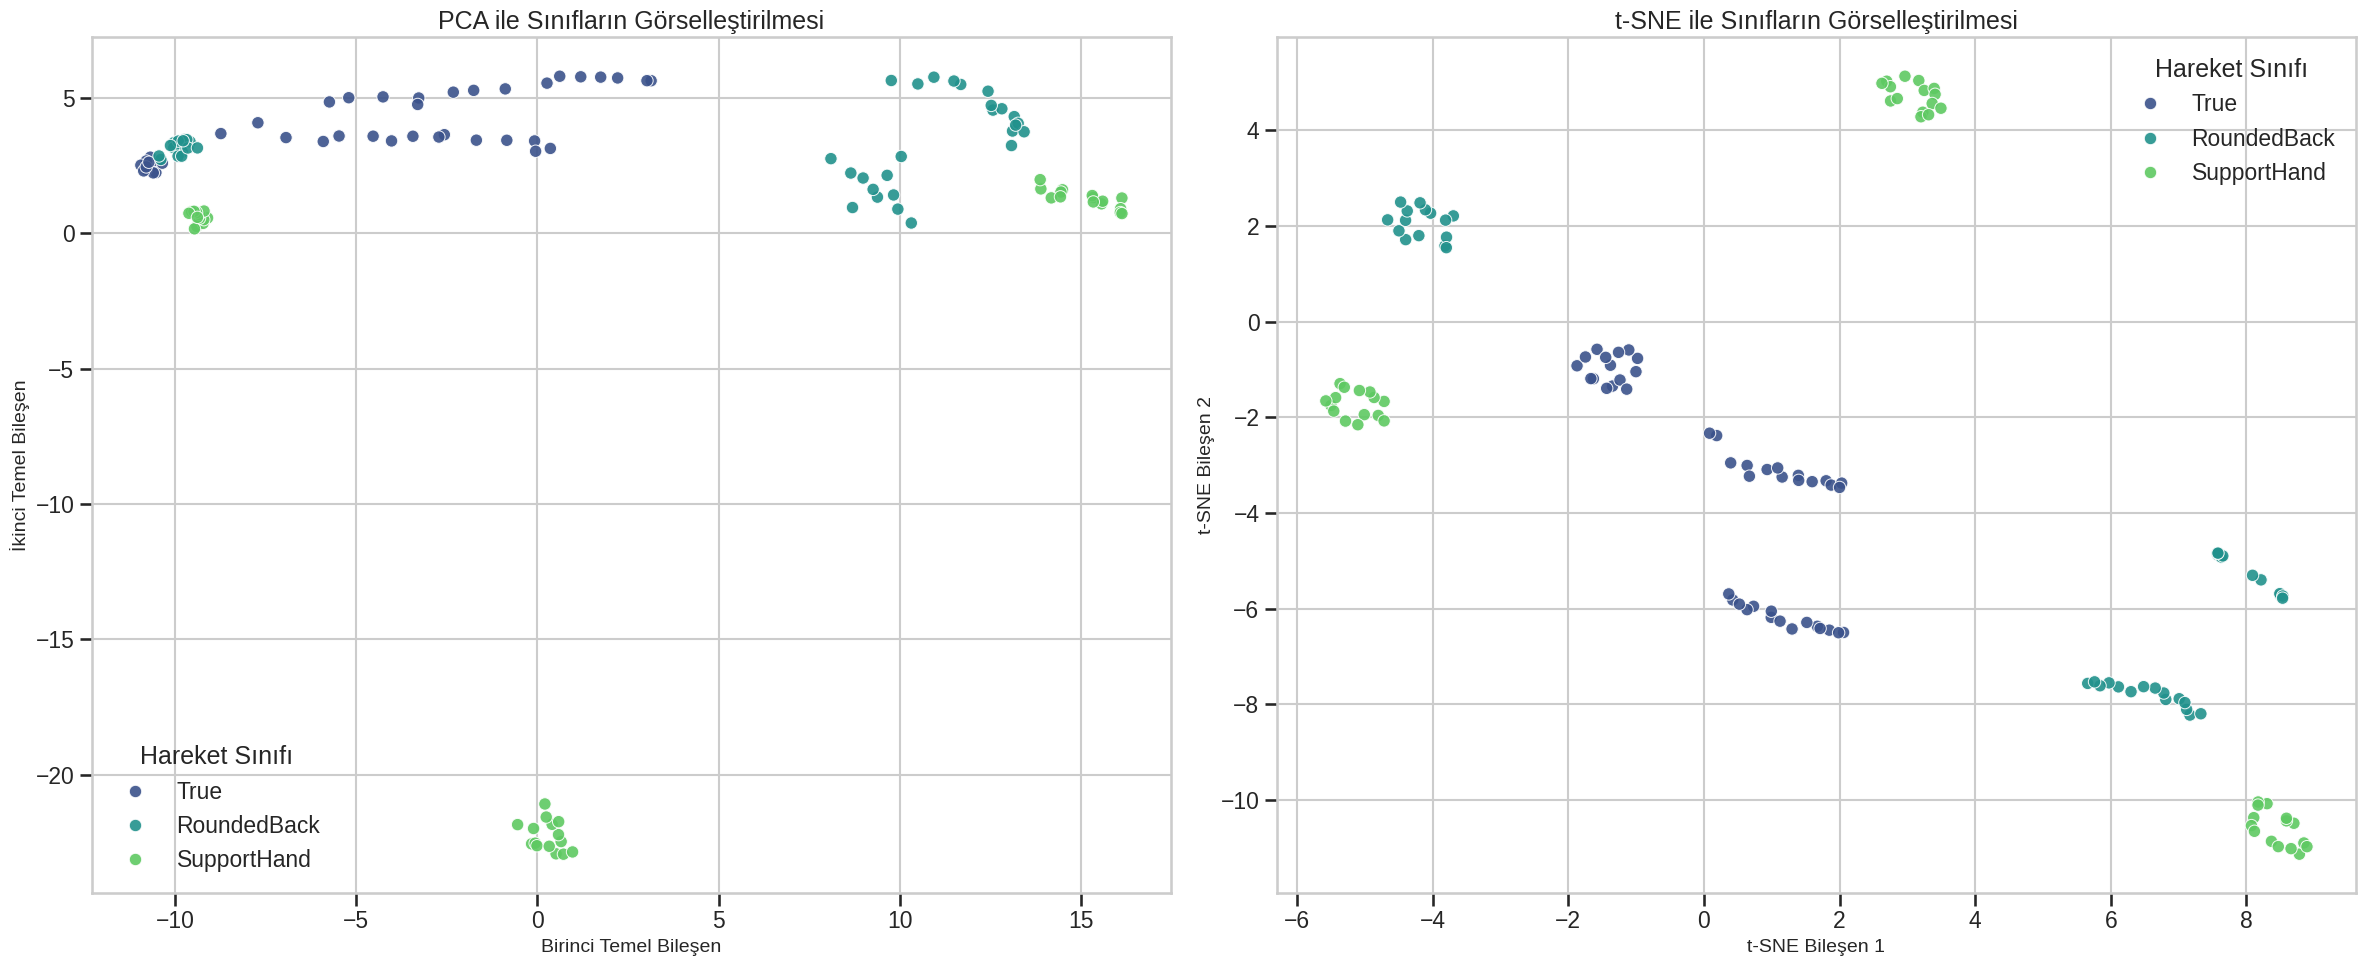


--- 'İlk An'a Göre Normalizasyon' ile Random Forest Performansı ---


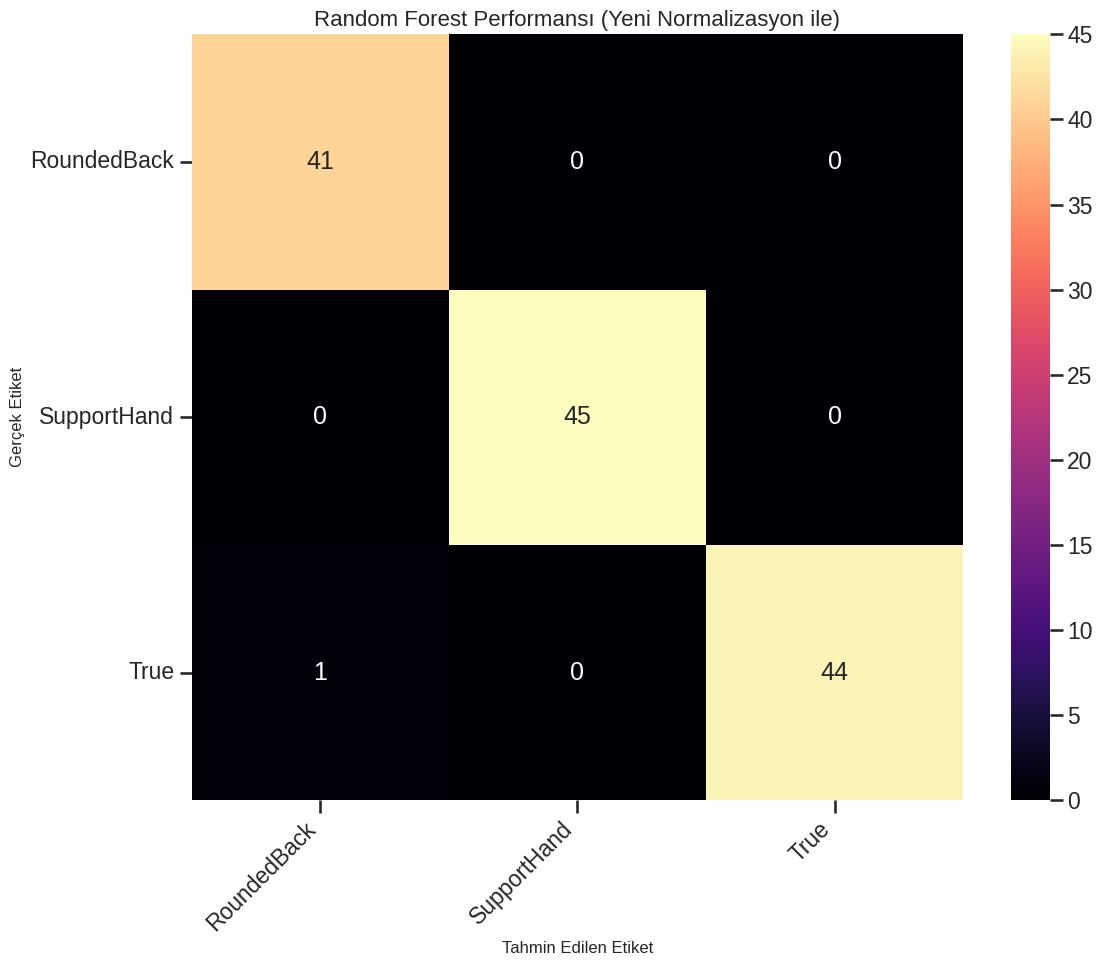


Random Forest Sınıflandırma Raporu (Yeni Normalizasyon ile):
              precision    recall  f1-score   support

 RoundedBack       0.98      1.00      0.99        41
 SupportHand       1.00      1.00      1.00        45
        True       1.00      0.98      0.99        45

    accuracy                           0.99       131
   macro avg       0.99      0.99      0.99       131
weighted avg       0.99      0.99      0.99       131



In [9]:
import os
import pickle
import numpy as np
import pandas as pd
from pyquaternion import Quaternion
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# --- AYARLAR ---
BASE_DATASET_FOLDER = ""
MOVEMENT_TO_ANALYZE = ""
USERS_TO_ANALYZE = ["User-A", "User-B", "User-E"]

# --- YENİ NORMALİZASYON MANTIĞI ---

def normalize_by_first_frame(movement_data_list):
    """
    Bir hareket kaydını, ayrı bir referans dosyası yerine
    kendi ilk anına göre normalize eder.
    """
    if not movement_data_list: return None
    
    # Referans olarak hareketin kendisini kullan
    npose_data_list = movement_data_list 
    
    normalized_movement = []
    for i in range(len(movement_data_list)):
        q_ref_row = npose_data_list[i].iloc[0]
        q_ref = Quaternion(w=q_ref_row['w'], x=q_ref_row['x'], y=q_ref_row['y'], z=q_ref_row['z'])
        q_ref_inverse = q_ref.inverse
        
        normalized_frames = []
        for row in movement_data_list[i].itertuples():
            live_quat = Quaternion(w=row.w, x=row.x, y=row.y, z=row.z)
            normalized_quat = q_ref_inverse * live_quat
            normalized_frames.append({'w': normalized_quat.w, 'x': normalized_quat.x, 'y': normalized_quat.y, 'z': normalized_quat.z})
            
        normalized_movement.append(pd.DataFrame(normalized_frames))
    return normalized_movement

# --- VERİ YÜKLEME VE YENİ NORMALİZASYON ---
all_movements_new_norm = []
print(f"'{MOVEMENT_TO_ANALYZE}' hareketi için YENİ normalizasyon ile veri yükleniyor...")

for user_id in USERS_TO_ANALYZE:
    user_path = os.path.join(BASE_DATASET_FOLDER, MOVEMENT_TO_ANALYZE, user_id)
    if not os.path.isdir(user_path): continue
    
    print(f"-> {user_id} işleniyor...")
    for label_folder in os.listdir(user_path):
        label_path = os.path.join(user_path, label_folder)
        if not os.path.isdir(label_path) or label_folder.startswith('tpose'): continue
        
        for movement_file in os.listdir(label_path):
            if not movement_file.startswith("movement_"): continue
            
            with open(os.path.join(label_path, movement_file), 'rb') as f:
                movement_dict = pickle.load(f)
            
            movement_raw = reshape_from_pkl(movement_dict['data'])
            # DİKKAT: normalize_by_first_frame fonksiyonu çağrılıyor
            movement_normalized = normalize_by_first_frame(movement_raw) 
            
            all_movements_new_norm.append({'data': movement_normalized, 'label': label_folder, 'user': user_id})

print(f"\nİşlem tamamlandı. Toplam {len(all_movements_new_norm)} hareket yeni yöntemle normalize edildi.")

# --- ÖZELLİK ÇIKARIMI VE MODELLEME ---
print("\nYeni normalize edilmiş veri ile özellik çıkarımı başlıyor...")
feature_list_new_norm = []
for movement in all_movements_new_norm:
    features = extract_features_for_movement(movement['data']) # Bu fonksiyon öncekiyle aynı
    features['label'] = movement['label']
    features['user'] = movement['user']
    feature_list_new_norm.append(features)

features_df_new_norm = pd.DataFrame(feature_list_new_norm)
print("Özellik çıkarımı tamamlandı.")

# Özellikleri (X) ve etiketleri (y) ayır
X = features_df.drop(['label', 'user'], axis=1)
y = features_df['label']

# Özellikleri ölçeklendir
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- PCA Analizi ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
print(f"PCA - Açıklanan Varyans Oranı: {sum(pca.explained_variance_ratio_)*100:.2f}%")

# --- t-SNE Analizi ---
print("t-SNE analizi başlıyor (biraz sürebilir)...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
print("t-SNE analizi tamamlandı.")


# Sonuçları tek bir figürde yan yana göster
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

# PCA Grafiği
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, palette='viridis', s=80, alpha=0.9, ax=ax1)
ax1.set_title('PCA ile Sınıfların Görselleştirilmesi', fontsize=18)
ax1.set_xlabel('Birinci Temel Bileşen', fontsize=14)
ax1.set_ylabel('İkinci Temel Bileşen', fontsize=14)
ax1.legend(title='Hareket Sınıfı')
ax1.grid(True)

# t-SNE Grafiği
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y, palette='viridis', s=80, alpha=0.9, ax=ax2)
ax2.set_title('t-SNE ile Sınıfların Görselleştirilmesi', fontsize=18)
ax2.set_xlabel('t-SNE Bileşen 1', fontsize=14)
ax2.set_ylabel('t-SNE Bileşen 2', fontsize=14)
ax2.legend(title='Hareket Sınıfı')
ax2.grid(True)

plt.tight_layout()
plt.show()

# --- RANDOM FOREST İLE TEST ---
X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_new = features_df_new_norm['label']
groups_new = features_df_new_norm['user']
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

print("\n--- 'İlk An'a Göre Normalizasyon' ile Random Forest Performansı ---")
model_rf =  LogisticRegression(max_iter=1000, random_state=42)
logo = LeaveOneGroupOut()
y_pred_overall_rf = np.array(y_new)

for train_idx, test_idx in logo.split(X_new, y_new, groups_new):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]
    
    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)
    
    model_rf.fit(X_train_scaled, y_train)
    y_pred_fold = model_rf.predict(X_test_scaled)
    y_pred_overall_rf[test_idx] = y_pred_fold

# Sonuçları göster
cm_rf = confusion_matrix(y_new, y_pred_overall_rf, labels=np.arange(len(le_new.classes_)))
plt.figure(figsize=(12, 10))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='magma',
            xticklabels=le_new.classes_, yticklabels=le_new.classes_)
plt.title("Random Forest Performansı (Yeni Normalizasyon ile)", fontsize=16)
plt.ylabel('Gerçek Etiket', fontsize=12)
plt.xlabel('Tahmin Edilen Etiket', fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

print("\nRandom Forest Sınıflandırma Raporu (Yeni Normalizasyon ile):")
print(classification_report(y_new, y_pred_overall_rf, target_names=le_new.classes_, zero_division=0))

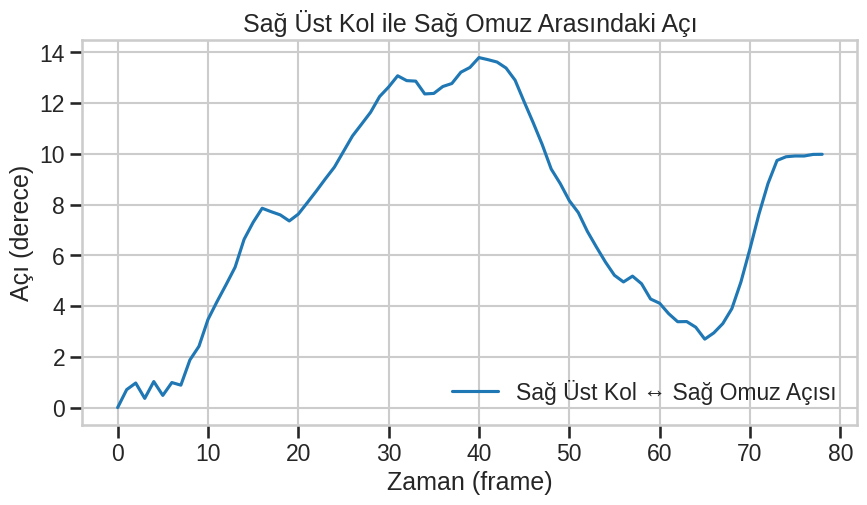

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from pyquaternion import Quaternion

def compute_angle_between_sensors(sensor_df1, sensor_df2):
    """
    İki sensör arasındaki açıyı derece cinsinden zaman serisi olarak döndürür.
    """
    angles = []
    for row1, row2 in zip(sensor_df1.itertuples(), sensor_df2.itertuples()):
        q1 = Quaternion(w=row1.w, x=row1.x, y=row1.y, z=row1.z)
        q2 = Quaternion(w=row2.w, x=row2.x, y=row2.y, z=row2.z)
        
        # relatif quaternion
        q_rel = q1.inverse * q2  
        
        # açıyı hesapla (radyan → derece)
        theta = 2 * np.arccos(np.clip(abs(q_rel.w), -1.0, 1.0))
        angles.append(np.degrees(theta))
    return np.array(angles)

# Örnek: hareketin normalize edilmiş ilk kaydında sağ üst kol (2) ile sağ omuz (3) arasındaki açı
movement = all_movements_new_norm[0]['data']  # ilk hareketin normalize datası
sensor2 = movement[1]  # sağ üst kol
sensor3 = movement[2]  # sağ omuz

angles = compute_angle_between_sensors(sensor2, sensor3)

# Grafiği çiz
plt.figure(figsize=(10,5))
plt.plot(angles, label="Sağ Üst Kol ↔ Sağ Omuz Açısı")
plt.xlabel("Zaman (frame)")
plt.ylabel("Açı (derece)")
plt.title("Sağ Üst Kol ile Sağ Omuz Arasındaki Açı")
plt.legend()
plt.grid(True)
plt.show()


In [13]:
# Bu hücrenin, Adım 2'de 'all_movements' listesini oluşturan hücreden sonra çalıştırıldığından emin ol.
# Çıktıların kaydedileceği klasör
OUTPUT_FOLDER = "report_figures"
if not os.path.exists(OUTPUT_FOLDER):
    os.makedirs(OUTPUT_FOLDER)

# Analiz edilecek hareket tipi (önceki hücrelerden alınır)
MOVEMENT_TO_ANALYZE = "ShoulderFlexion" 
USERS_TO_ANALYZE = ["User-A", "User-B", "User-C", "User-D"]

print(f"--- Kullanıcı Bazlı Birleştirilmiş Isı Haritaları Oluşturuluyor ---")

def reshape_to_matrix(list_of_dfs):
    """10 DataFrame'den oluşan listeyi (timesteps, 40) boyutunda tek bir matrise dönüştürür."""
    if not list_of_dfs or len(list_of_dfs[0]) == 0: return np.array([])
    num_timesteps = len(list_of_dfs[0])
    num_sensors = len(list_of_dfs)
    matrix = np.zeros((num_timesteps, num_sensors * 4))
    for t in range(num_timesteps):
        frame = [val for s in range(num_sensors) for val in list_of_dfs[s].iloc[t][['x', 'y', 'z', 'w']].values]
        matrix[t, :] = frame
    return matrix

for user in USERS_TO_ANALYZE:
    print(f"\n-> {user} için harita oluşturuluyor...")
    
    # İlgili kullanıcıya ait tüm hareketleri filtrele
    user_movements = [m for m in all_movements if m['user'] == user]
    
    if not user_movements:
        print(f"   - {user} için veri bulunamadı, atlanıyor.")
        continue

    # Daha iyi görsel karşılaştırma için etiketlere göre sırala
    user_movements.sort(key=lambda x: x['label'])
    
    # Hareketleri matris formatına dönüştür ve birleştir
    movements_to_concat = [reshape_to_matrix(m['data']) for m in user_movements]
    concatenated_data = np.vstack(movements_to_concat)
    
    print(f"   - Birleştirilmiş veri matrisinin boyutu: {concatenated_data.shape}")

    # --- Isı Haritasını Çizdir ---
    plt.figure(figsize=(20, 10))
    sns.heatmap(concatenated_data.T, cmap='viridis', cbar=True)

    # --- Ayırıcı Çizgileri ve Etiketleri Ekle ---
    separator_positions = []
    label_positions = []
    current_pos = 0
    for i, arr in enumerate(movements_to_concat):
        start_pos = current_pos
        current_pos += arr.shape[0]
        separator_positions.append(current_pos)
        label_positions.append((start_pos + current_pos) / 2)

    plt.vlines(x=separator_positions, ymin=0, ymax=concatenated_data.shape[1], 
               colors='white', ls='--', lw=1.0, alpha=0.9)

    # --- Başlık ve Eksen Etiketleri ---
    plt.title(f"Combined Movement Heat Map - User: {user}", fontsize=16)
    plt.ylabel("Sensors (s1–s10) and Axes (x, y, z, w)", fontsize=12)
    plt.xlabel("Combined Time Steps (Each dashed line indicates a new movement)", fontsize=12)

    y_ticks_labels = [f"s{i//4 + 1}_{['x','y','z','w'][i%4]}" for i in range(40)]
    plt.yticks(ticks=np.arange(len(y_ticks_labels)) + 0.5, labels=y_ticks_labels, rotation=0, fontsize=8)
    
    # X eksenine sınıf etiketlerini ekle
    unique_labels = [m['label'] for m in user_movements]
    # Etiket tekrarını önlemek için daha basit bir yöntem
    simple_labels = []
    last_label = ""
    for label in unique_labels:
        if label != last_label:
            simple_labels.append(label)
            last_label = label

    # Bu kısım etiketlerin nereye konulacağını hesaplar, biraz karmaşık olabilir
    label_change_indices = [i for i in range(1, len(unique_labels)) if unique_labels[i] != unique_labels[i-1]]
    label_tick_positions = [label_positions[0]] + [label_positions[i] for i in label_change_indices]
    
    ax = plt.gca()
    ax.set_xticks(label_tick_positions)
    ax.set_xticklabels(simple_labels, rotation=45, ha='center', fontsize=10)
    
    # Dosyayı kaydet
    filename = f"concatenated_heatmap_{user}.png"
    plt.savefig(os.path.join(OUTPUT_FOLDER, filename))
    plt.close()
    print(f"   - Harita kaydedildi: {filename}")

print("\n--- Tüm kullanıcı haritaları başarıyla oluşturuldu. ---")

--- Kullanıcı Bazlı Birleştirilmiş Isı Haritaları Oluşturuluyor ---

-> User-A için harita oluşturuluyor...
   - Birleştirilmiş veri matrisinin boyutu: (3557, 40)
   - Harita kaydedildi: concatenated_heatmap_User-A.png

-> User-B için harita oluşturuluyor...
   - Birleştirilmiş veri matrisinin boyutu: (4724, 40)
   - Harita kaydedildi: concatenated_heatmap_User-B.png

-> User-C için harita oluşturuluyor...
   - User-C için veri bulunamadı, atlanıyor.

-> User-D için harita oluşturuluyor...
   - User-D için veri bulunamadı, atlanıyor.

--- Tüm kullanıcı haritaları başarıyla oluşturuldu. ---


t-SNE analysis started (this may take a while)...
t-SNE analysis completed.


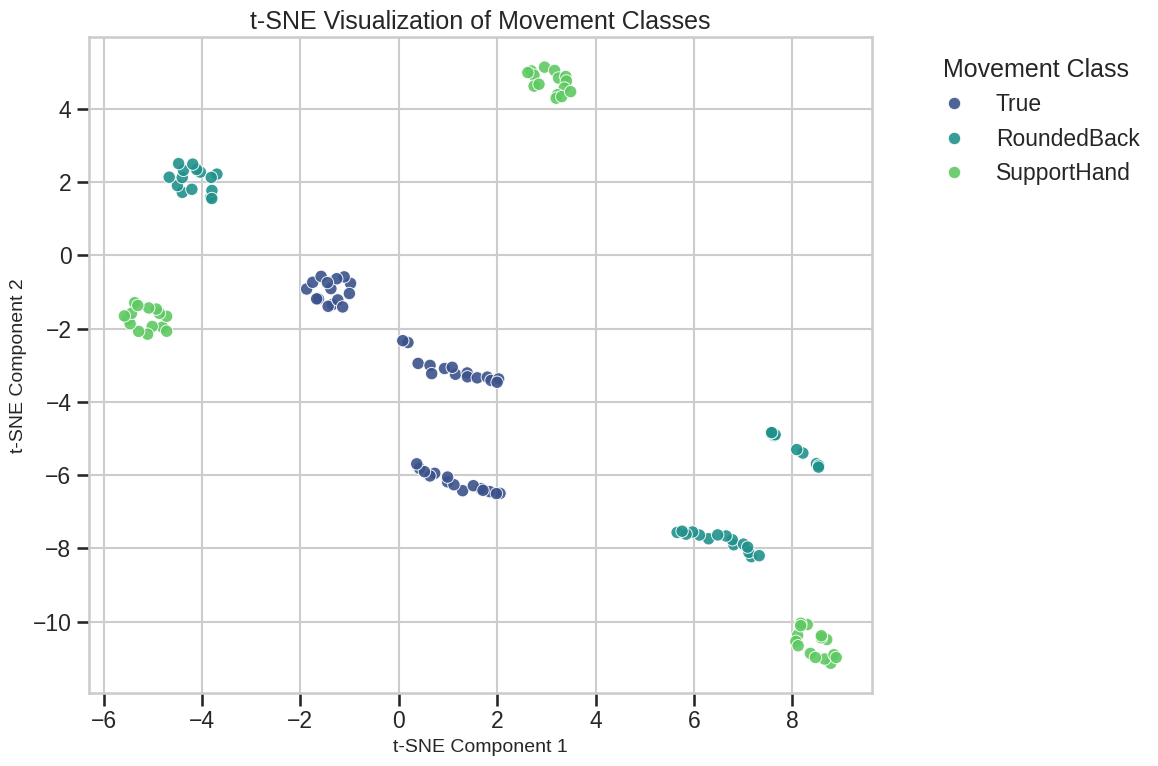

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# --- Features (X) and labels (y) ---
X = features_df.drop(['label', 'user'], axis=1)
y = features_df['label']

# --- Feature scaling ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- t-SNE Analysis ---
print("t-SNE analysis started (this may take a while)...")
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
X_tsne = tsne.fit_transform(X_scaled)
print("t-SNE analysis completed.")

# --- Visualization ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x=X_tsne[:, 0], 
    y=X_tsne[:, 1], 
    hue=y, 
    palette='viridis', 
    s=80, 
    alpha=0.9
)
plt.title("t-SNE Visualization of Movement Classes", fontsize=18)
plt.xlabel("t-SNE Component 1", fontsize=14)
plt.ylabel("t-SNE Component 2", fontsize=14)
plt.legend(title="Movement Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()



--- Model Comparison with First-Frame Normalization ---


/opt/conda/envs/python313/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=4).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [03:45:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 4 iteration(s) (sta


--- Final Model Comparison ---
                 Model  Average Accuracy  Average F1-Score
2  Logistic Regression          0.991870          0.991906
3                  KNN          0.977055          0.976802
0        Random Forest          0.975610          0.975718
4              XGBoost          0.633604          0.568025
1                  SVM          0.628907          0.558300


/tmp/ipykernel_149/3033443583.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="viridis")


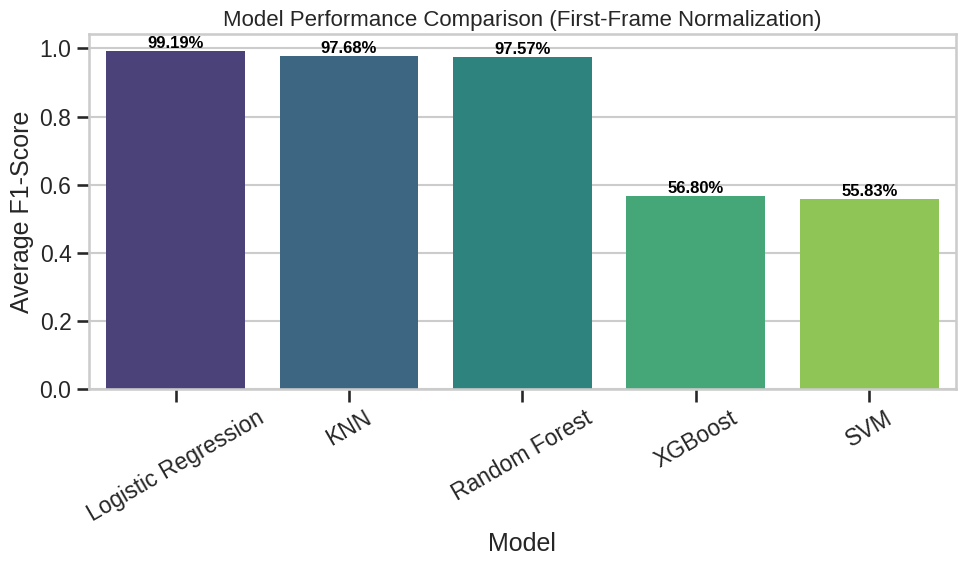

In [25]:
# --- MODELLEME VE KARŞILAŞTIRMA ---

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score

# Özellikleri (X) ve etiketleri (y) ayır
X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_new = features_df_new_norm['label']
groups_new = features_df_new_norm['user']
le_new = LabelEncoder().fit(y_str_new)
y_new = le_new.transform(y_str_new)

# Modelleri tanımla
models = {
    "Random Forest": RandomForestClassifier(n_estimators=18, random_state=1234, n_jobs=-1),
    "SVM": SVC(kernel='rbf', probability=True, random_state=32),
    "Logistic Regression": LogisticRegression(max_iter=4, random_state=5343),
    "KNN": KNeighborsClassifier(n_neighbors=6),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=1231223)
}

logo = LeaveOneGroupOut()
results = {name: [] for name in models.keys()}

print("\n--- Model Comparison with First-Frame Normalization ---")

# Her model için Leave-One-Group-Out CV
for train_idx, test_idx in logo.split(X_new, y_new, groups_new):
    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]

    scaler = StandardScaler().fit(X_train)
    X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)

        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        results[name].append({"accuracy": acc, "f1_score": f1})

# Sonuçları özetle
summary = []
for name, scores in results.items():
    avg_acc = np.mean([s["accuracy"] for s in scores])
    avg_f1 = np.mean([s["f1_score"] for s in scores])
    summary.append({"Model": name, "Average Accuracy": avg_acc, "Average F1-Score": avg_f1})

summary_df = pd.DataFrame(summary).sort_values("Average F1-Score", ascending=False)
print("\n--- Final Model Comparison ---")
print(summary_df)

# Sonuçları grafikle göster
plt.figure(figsize=(10,6))
ax = sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette="viridis")

# Çubukların üzerine değerleri yaz
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%",  # yüzdelik format
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom',
                fontsize=12, color='black', fontweight='bold')

plt.title("Model Performance Comparison (First-Frame Normalization)", fontsize=16)
plt.ylabel("Average F1-Score")
plt.xticks(rotation=30)
plt.tight_layout()
plt.savefig("model_comparison_firstframe.png")
plt.show()

/tmp/ipykernel_215/3683521381.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette=gray_palette, ax=ax)


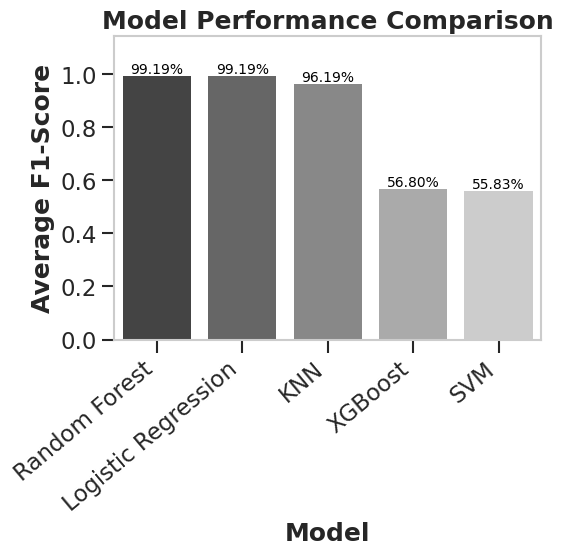

In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Veri
summary_data = {'Model': ['Random Forest', 'Logistic Regression', 'KNN', 'XGBoost', 'SVM'],
                'Average F1-Score': [0.9919, 0.9919, 0.9619, 0.5680, 0.5583]}
summary_df = pd.DataFrame(summary_data).sort_values("Average F1-Score", ascending=False)

# 2. Grafik Ayarları
cm_to_inch = 1/2.54
figure_width_cm = 14
figure_height_cm = 10 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'font.size': 11,
    'axes.linewidth': 1.5,
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5
})

# 3. Grafik Çizimi
fig, ax = plt.subplots(figsize=(figure_width_cm * cm_to_inch, figure_height_cm * cm_to_inch))
gray_palette = ['#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC']
sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette=gray_palette, ax=ax)

# 4. Detaylar
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=10, color='black')

ax.set_title("Model Performance Comparison", fontweight='bold')
ax.set_ylabel("Average F1-Score", fontweight='bold')
ax.set_xlabel("Model", fontweight='bold')
plt.xticks(rotation=40, ha='right')
ax.grid(False)
ax.set_ylim(0, max(summary_df["Average F1-Score"]) * 1.15)

# --- DÜZELTME BURADA ---
# plt.tight_layout() komutunu kaldırıyoruz çünkü bbox_inches='tight' ile çakışabilir.

# 5. Kaydetme (En Önemli Değişiklik)
# bbox_inches='tight' parametresi, figürdeki her şeyin (başlık, etiketler vb.)
# kesilmeden dosyaya sığdırılmasını sağlar.
plt.savefig("model_comparison_PERFECT_final.png", dpi=300, bbox_inches='tight')

plt.show()

/tmp/ipykernel_215/591807836.py:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette=gray_palette, ax=ax)


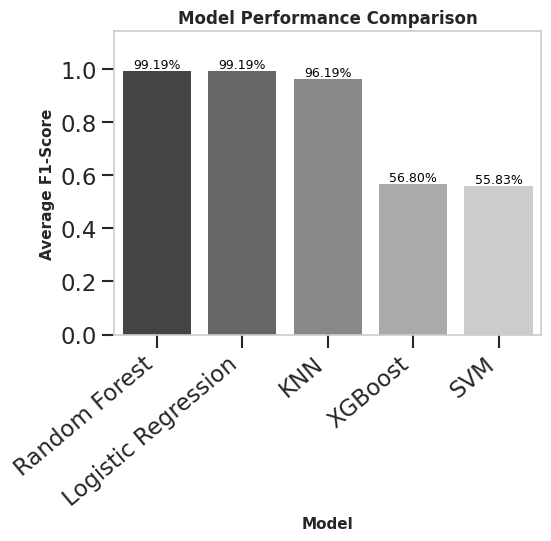

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Veri
summary_data = {'Model': ['Random Forest', 'Logistic Regression', 'KNN', 'XGBoost', 'SVM'],
                'Average F1-Score': [0.9919, 0.9919, 0.9619, 0.5680, 0.5583]}
summary_df = pd.DataFrame(summary_data).sort_values("Average F1-Score", ascending=False)

# 2. Grafik Ayarları
cm_to_inch = 1/2.54
figure_width_cm = 14
figure_height_cm = 10 

# --- DÜZELTME: Genel puntoyu düşürüp, başlıkları ayrıca kontrol edelim ---
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'font.size': 10,  # Genel metin ve sayı puntosunu 11'den 10'a düşürdük
    'axes.linewidth': 1.2, # Çizgi kalınlığını biraz inceltebiliriz
})

# 3. Grafik Çizimi
fig, ax = plt.subplots(figsize=(figure_width_cm * cm_to_inch, figure_height_cm * cm_to_inch))
gray_palette = ['#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC']
sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette=gray_palette, ax=ax)

# 4. Detaylar
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', 
                fontsize=9, # Çubuk üzerindeki yazıların puntosunu da küçülttük
                color='black')

# --- DÜZELTME: Başlık ve etiketlere özel, dengeli punto boyutları atayalım ---
ax.set_title("Model Performance Comparison", fontweight='bold', fontsize=12) # Ana başlık
ax.set_ylabel("Average F1-Score", fontweight='bold', fontsize=11) # Y Ekseni
ax.set_xlabel("Model", fontweight='bold', fontsize=11) # X Ekseni

# X eksenindeki model isimlerinin puntosu rcParams'dan (10pt) gelecek, bu ideal.
plt.xticks(rotation=40, ha='right')
ax.grid(False)
ax.set_ylim(0, max(summary_df["Average F1-Score"]) * 1.15)

# 5. Kaydetme
plt.savefig("model_comparison_final_balanced.png", dpi=300, bbox_inches='tight')

plt.show()

/tmp/ipykernel_215/3792432350.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette=gray_palette, ax=ax)


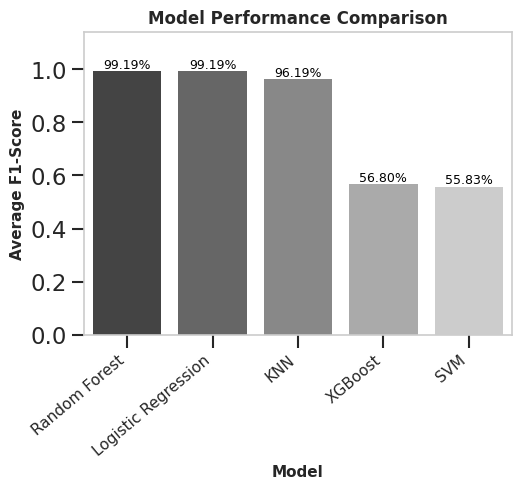

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Veri
summary_data = {'Model': ['Random Forest', 'Logistic Regression', 'KNN', 'XGBoost', 'SVM'],
                'Average F1-Score': [0.9919, 0.9919, 0.9619, 0.5680, 0.5583]}
summary_df = pd.DataFrame(summary_data).sort_values("Average F1-Score", ascending=False)

# 2. Grafik Ayarları
cm_to_inch = 1/2.54
figure_width_cm = 14
figure_height_cm = 10 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'font.size': 10,
    'axes.linewidth': 1.2,
})

# 3. Grafik Çizimi
fig, ax = plt.subplots(figsize=(figure_width_cm * cm_to_inch, figure_height_cm * cm_to_inch))
gray_palette = ['#444444', '#666666', '#888888', '#AAAAAA', '#CCCCCC']
sns.barplot(x="Model", y="Average F1-Score", data=summary_df, palette=gray_palette, ax=ax)

# 4. Detaylar
for p in ax.patches:
    ax.annotate(f"{p.get_height()*100:.2f}%",
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', 
                fontsize=9,
                color='black')

ax.set_title("Model Performance Comparison", fontweight='bold', fontsize=12)
ax.set_ylabel("Average F1-Score", fontweight='bold', fontsize=11)
ax.set_xlabel("Model", fontweight='bold', fontsize=11)

# --- DEĞİŞİKLİK BURADA ---
# X eksenindeki model isimlerinin (tick labels) puntosunu 9'a düşürüyoruz.
plt.xticks(rotation=40, ha='right', fontsize=11)

ax.grid(False)
ax.set_ylim(0, max(summary_df["Average F1-Score"]) * 1.15)

# 5. Kaydetme
plt.savefig("model_comparison_final_final.png", dpi=300, bbox_inches='tight')

plt.show()

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE

# BU NOKTADA SENİN 'features_df' DATAFRAME'İNİN YÜKLENMİŞ VE HAZIR OLDUĞUNU VARSAYIYORUZ.
# ÖRNEK VERİ OLUŞTURMA KISMI BU KODDAN TAMAMEN KALDIRILMIŞTIR.


# --- 1. t-SNE Hesaplaması (Doğrudan senin verinle) ---
X = features_df.drop(['label'], axis=1, errors='ignore')
y = features_df['label']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', random_state=42)
X_tsne = tsne.fit_transform(X_scaled)

tsne_df = pd.DataFrame(data=X_tsne, columns=['t-SNE Component 1', 't-SNE Component 2'])
tsne_df['Movement Class'] = y


# --- 2. Grafik Ayarları (Standart formatımız) ---
cm_to_inch = 1/2.54
figure_width_cm = 14
figure_height_cm = 12 

plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['DejaVu Sans', 'Arial'],
    'font.size': 10,
    'axes.linewidth': 1.2,
})


# --- 3. Grafiği RENKLİ ve Yeni Formatta Çizdirme ---
fig, ax = plt.subplots(figsize=(figure_width_cm * cm_to_inch, figure_height_cm * cm_to_inch))

sns.scatterplot(
    data=tsne_df,
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    hue='Movement Class',
    palette='viridis',
    s=60,
    alpha=0.9,
    ax=ax
)

# --- 4. Detaylar ve Başlıklar ---
ax.set_title("t-SNE Visualization of Movement Classes", fontweight='bold', fontsize=12)
ax.set_ylabel("t-SNE Component 2", fontweight='bold', fontsize=11)
ax.set_xlabel("t-SNE Component 1", fontweight='bold', fontsize=11)
ax.grid(False)

legend = ax.legend(title="Movement Class")
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)


# --- 5. Kaydetme ---
plt.savefig("tSNE_plot_formatted_color_CORRECT_DATA.png", dpi=300, bbox_inches='tight')
plt.show()

ValueError: could not convert string to float: 'User-A'


--- Feature Importance Calculation ---
Eğitiliyor: Random Forest...
{'Random Forest': [{'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 0.975609756097561, 'f1_score': 0.9757194573444985}, {'accuracy': 1.0, 'f1_score': 1.0}], 'SVM': [{'accuracy': 0.3333333333333333, 'f1_score': 0.16666666666666666}, {'accuracy': 0.5777777777777777, 'f1_score': 0.5325130052020809}, {'accuracy': 0.975609756097561, 'f1_score': 0.9757194573444985}], 'Logistic Regression': [{'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 0.975609756097561, 'f1_score': 0.9757194573444985}], 'KNN': [{'accuracy': 0.9555555555555556, 'f1_score': 0.9553571428571429}, {'accuracy': 0.9555555555555556, 'f1_score': 0.9546850998463902}, {'accuracy': 0.975609756097561, 'f1_score': 0.9757194573444985}], 'XGBoost': [{'accuracy': 0.8, 'f1_score': 0.7995391705069125}, {'accuracy': 0.4666666666666667, 'f1_score': 0.3791554357592094}, {'accuracy': 0.6341463414634146, '

/opt/conda/envs/python313/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:11:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


{'Random Forest': [{'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 0.975609756097561, 'f1_score': 0.9757194573444985}, {'accuracy': 1.0, 'f1_score': 1.0}], 'SVM': [{'accuracy': 0.3333333333333333, 'f1_score': 0.16666666666666666}, {'accuracy': 0.5777777777777777, 'f1_score': 0.5325130052020809}, {'accuracy': 0.975609756097561, 'f1_score': 0.9757194573444985}], 'Logistic Regression': [{'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 1.0, 'f1_score': 1.0}, {'accuracy': 0.975609756097561, 'f1_score': 0.9757194573444985}], 'KNN': [{'accuracy': 0.9555555555555556, 'f1_score': 0.9553571428571429}, {'accuracy': 0.9555555555555556, 'f1_score': 0.9546850998463902}, {'accuracy': 0.975609756097561, 'f1_score': 0.9757194573444985}], 'XGBoost': [{'accuracy': 0.8, 'f1_score': 0.7995391705069125}, {'accuracy': 0.4666666666666667, 'f1_score': 0.3791554357592094}, {'accuracy': 0.6341463414634146, 'f1_score': 0.5253790375741595}, {'accuracy': 0.975609756097561, 'f1_s

/tmp/ipykernel_147/407062052.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances.values, y=top_importances.index, palette="viridis")


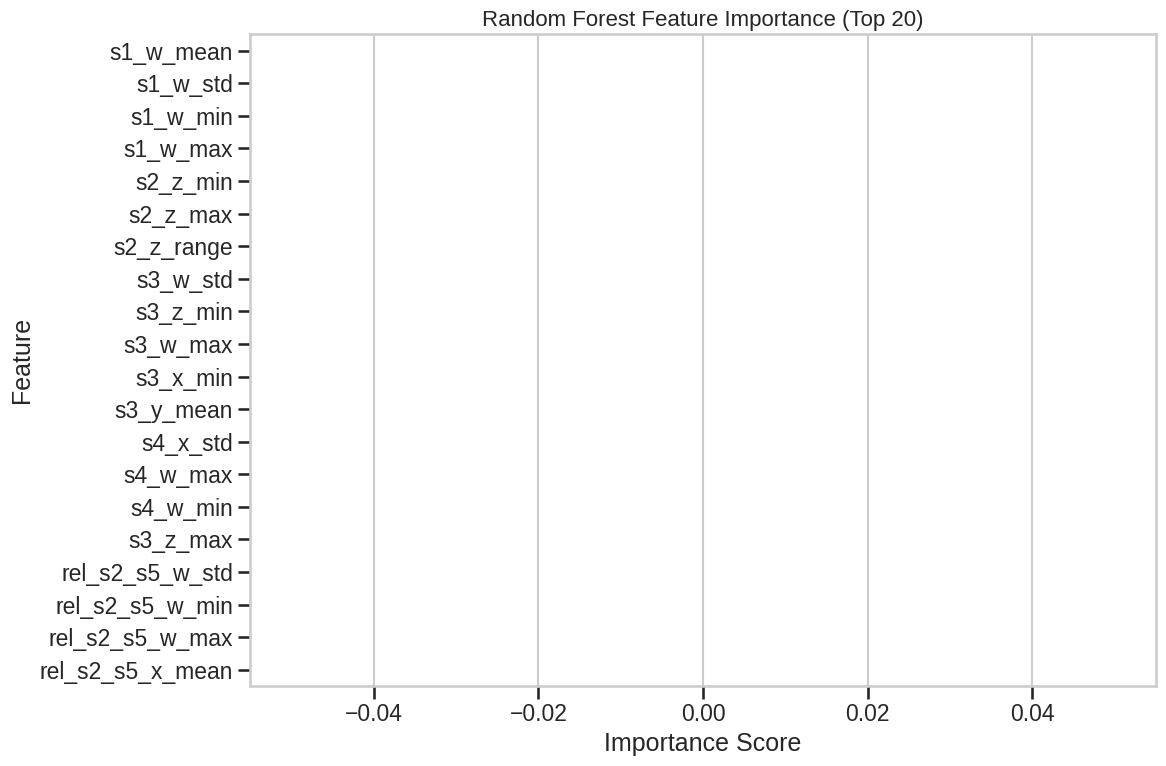

/tmp/ipykernel_147/407062052.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances.values, y=top_importances.index, palette="viridis")


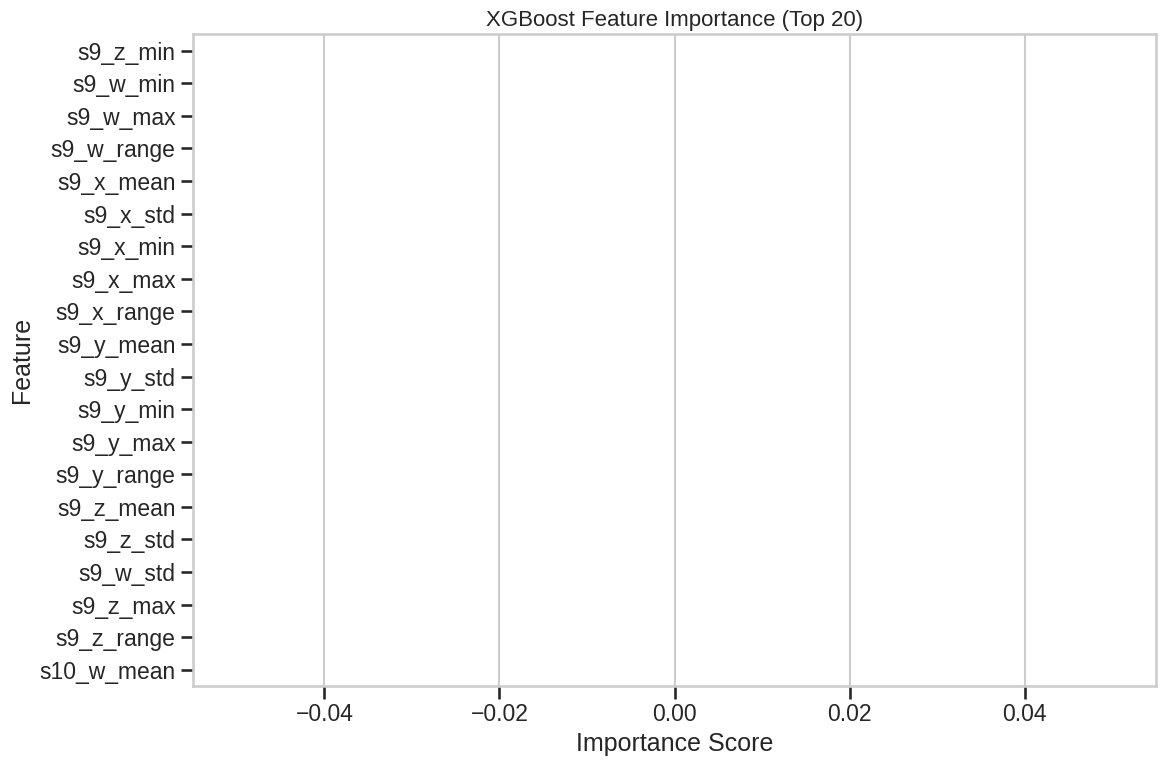


--- Logistic Regression (Coefficient Magnitude) ---
s3_y_max             0.095716
s7_y_std             0.081729
s7_y_range           0.078792
rel_s3_s8_y_range    0.078759
s5_y_std             0.073967
dtype: float64


/tmp/ipykernel_147/407062052.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_abs_coeffs.values, y=top_abs_coeffs.index, palette="magma")


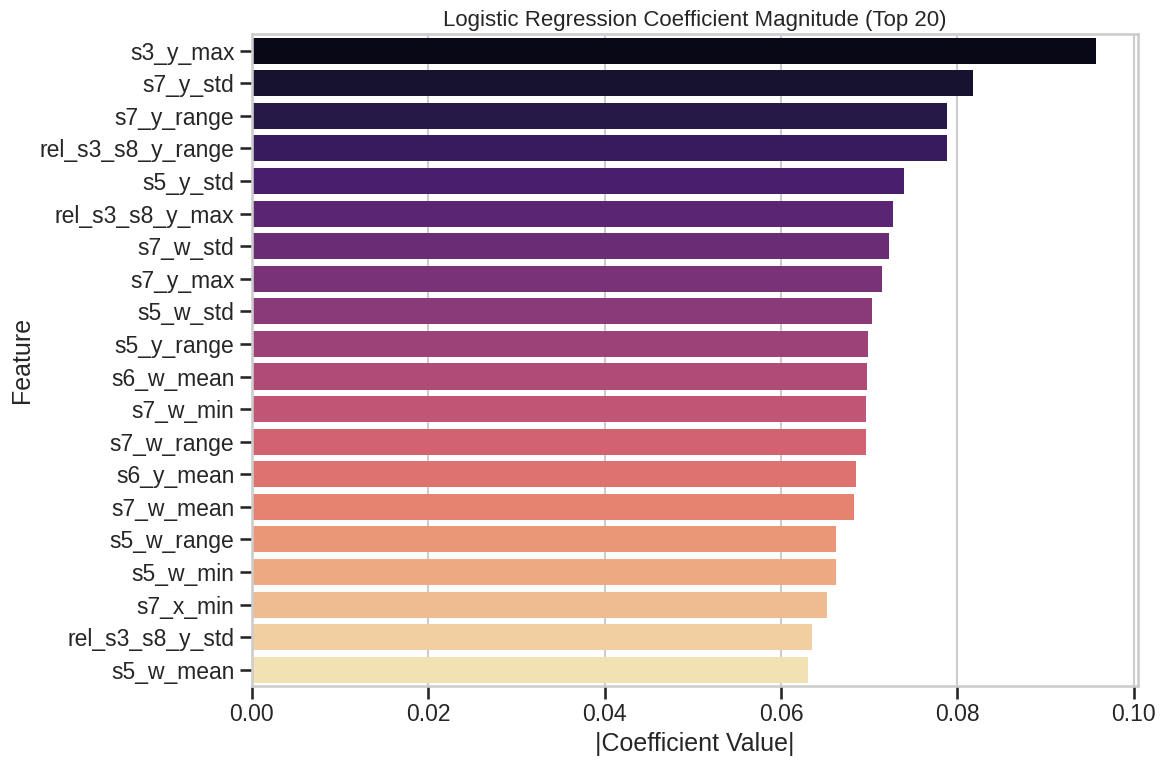

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

# --- VERİ HAZIRLIĞI (Mevcut kodunuzdan varsayılan) ---
# X_new, y_new ve features_df_new_norm'un önceki kodunuzdan geldiği varsayılır.
# Örn:
# X_new = features_df_new_norm.drop(['label', 'user'], axis=1)
# y_new = le_new.transform(features_df_new_norm['label'])

# Veri setini standardizasyon için hazırlayın
scaler = StandardScaler().fit(X_new)
X_scaled = scaler.transform(X_new)
X_scaled_df = pd.DataFrame(X_scaled, columns=X_new.columns)

# Modelleri tanımla (Sadece özellik önemi olanlar)
importance_models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

feature_importance_results = {}
pd.set_option('display.max_rows', None)


print("\n--- Feature Importance Calculation ---")

for name, model in importance_models.items():
    print(f"Eğitiliyor: {name}...")
    # Modeli tüm ölçeklenmiş veri kümesi üzerinde eğitin
    model.fit(X_scaled_df, y_new)

    if name == "Random Forest":
        # Random Forest: Gini düşüşüne dayalı özellik önemi
        importances = model.feature_importances_
    elif name == "XGBoost":
        # XGBoost: Kazanca (Gain) dayalı özellik önemi
        importances = model.feature_importances_
    
    # Özellik önemlerini bir DataFrame'de topla
    feature_importances = pd.Series(importances, index=X_scaled_df.columns)
    feature_importances = feature_importances.sort_values(ascending=True)
    
    y_pred = model.predict(X_test_scaled)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    results[name].append({"accuracy": acc, "f1_score": f1})
    print(results)
    
    feature_importance_results[name] = feature_importances
    print(f"{name} için en önemli 5 özellik:")
    print(feature_importances)
    print("-" * 30)

# --- Sonuçları Görselleştirme ---



num_features_to_show = 20  # Gösterilecek özellik sayısı

for name, importances in feature_importance_results.items():
    plt.figure(figsize=(12, 8))
    # İlk X özelliği al
    top_importances = importances.head(num_features_to_show)
    
    sns.barplot(x=top_importances.values, y=top_importances.index, palette="viridis")
    plt.title(f"{name} Feature Importance (Top {num_features_to_show})", fontsize=16)
    plt.xlabel("Importance Score")
    plt.ylabel("Feature")
    plt.tight_layout()
    plt.show()
    #  - Bu, yukarıdaki kodu çalıştırdıktan sonra oluşturulacak grafik.

# --- Logistic Regression için alternatif (Katsayılar) ---
# Logistic Regression için katsayılar (coefficients) incelenebilir.
# Bu, doğrusal ilişkileri gösterir ve bir önem göstergesi olarak kullanılabilir.

log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_scaled_df, y_new)

# Katsayıların mutlak değerlerine göre sıralanması
coefficients = pd.Series(log_reg.coef_[0], index=X_scaled_df.columns)
# Mutlak değerlerini alıyoruz çünkü işaret (pozitif/negatif) sadece yönü belirtir,
# büyüklük ise önemi belirtir.
abs_coefficients = coefficients.abs().sort_values(ascending=False)

print("\n--- Logistic Regression (Coefficient Magnitude) ---")
print(abs_coefficients.head(5))

# Katsayıları görselleştirme (sadece en önemli 20)
plt.figure(figsize=(12, 8))
top_abs_coeffs = abs_coefficients.head(num_features_to_show)
sns.barplot(x=top_abs_coeffs.values, y=top_abs_coeffs.index, palette="magma")
plt.title(f"Logistic Regression Coefficient Magnitude (Top {num_features_to_show})", fontsize=16)
plt.xlabel("|Coefficient Value|")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
#  - Bu da ikinci bir grafik.

Toplam 1024 farklı sensör çıkarma senaryosu test edilecek (Her model için 131 katlama). Bu süreç zaman alabilir.
--------------------------------------------------------------------------------
[1/1024] Deneniyor: 0-REFERANS (Tümü) | Kalan Özellik Sayısı: 260


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[2/1024] Deneniyor: 1-Çıkarılan: REL (Bağıl Özellikler) | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[3/1024] Deneniyor: 1-Çıkarılan: S1 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[4/1024] Deneniyor: 1-Çıkarılan: S2 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[5/1024] Deneniyor: 1-Çıkarılan: S3 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[6/1024] Deneniyor: 1-Çıkarılan: S4 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[7/1024] Deneniyor: 1-Çıkarılan: S5 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[8/1024] Deneniyor: 1-Çıkarılan: S6 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[9/1024] Deneniyor: 1-Çıkarılan: S7 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[10/1024] Deneniyor: 1-Çıkarılan: S8 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[11/1024] Deneniyor: 1-Çıkarılan: S9 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[12/1024] Deneniyor: 1-Çıkarılan: S10 | Kalan Özellik Sayısı: 240


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[13/1024] Deneniyor: 2-Çıkarılan: S1, S2 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[14/1024] Deneniyor: 2-Çıkarılan: S1, S3 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[15/1024] Deneniyor: 2-Çıkarılan: S1, S4 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[16/1024] Deneniyor: 2-Çıkarılan: S1, S5 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[17/1024] Deneniyor: 2-Çıkarılan: S1, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[18/1024] Deneniyor: 2-Çıkarılan: S1, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[19/1024] Deneniyor: 2-Çıkarılan: S1, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[20/1024] Deneniyor: 2-Çıkarılan: S1, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[21/1024] Deneniyor: 2-Çıkarılan: S1, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[22/1024] Deneniyor: 2-Çıkarılan: S2, S3 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[23/1024] Deneniyor: 2-Çıkarılan: S2, S4 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[24/1024] Deneniyor: 2-Çıkarılan: S2, S5 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[25/1024] Deneniyor: 2-Çıkarılan: S2, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[26/1024] Deneniyor: 2-Çıkarılan: S2, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[27/1024] Deneniyor: 2-Çıkarılan: S2, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[28/1024] Deneniyor: 2-Çıkarılan: S2, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[29/1024] Deneniyor: 2-Çıkarılan: S2, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[30/1024] Deneniyor: 2-Çıkarılan: S3, S4 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[31/1024] Deneniyor: 2-Çıkarılan: S3, S5 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[32/1024] Deneniyor: 2-Çıkarılan: S3, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[33/1024] Deneniyor: 2-Çıkarılan: S3, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[34/1024] Deneniyor: 2-Çıkarılan: S3, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[35/1024] Deneniyor: 2-Çıkarılan: S3, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[36/1024] Deneniyor: 2-Çıkarılan: S3, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[37/1024] Deneniyor: 2-Çıkarılan: S4, S5 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[38/1024] Deneniyor: 2-Çıkarılan: S4, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[39/1024] Deneniyor: 2-Çıkarılan: S4, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[40/1024] Deneniyor: 2-Çıkarılan: S4, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[41/1024] Deneniyor: 2-Çıkarılan: S4, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[42/1024] Deneniyor: 2-Çıkarılan: S4, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[43/1024] Deneniyor: 2-Çıkarılan: S5, S6 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[44/1024] Deneniyor: 2-Çıkarılan: S5, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[45/1024] Deneniyor: 2-Çıkarılan: S5, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[46/1024] Deneniyor: 2-Çıkarılan: S5, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[47/1024] Deneniyor: 2-Çıkarılan: S5, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[48/1024] Deneniyor: 2-Çıkarılan: S6, S7 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[49/1024] Deneniyor: 2-Çıkarılan: S6, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[50/1024] Deneniyor: 2-Çıkarılan: S6, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[51/1024] Deneniyor: 2-Çıkarılan: S6, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[52/1024] Deneniyor: 2-Çıkarılan: S7, S8 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[53/1024] Deneniyor: 2-Çıkarılan: S7, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[54/1024] Deneniyor: 2-Çıkarılan: S7, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[55/1024] Deneniyor: 2-Çıkarılan: S8, S9 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[56/1024] Deneniyor: 2-Çıkarılan: S8, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:12:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[57/1024] Deneniyor: 2-Çıkarılan: S9, S10 | Kalan Özellik Sayısı: 220


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[58/1024] Deneniyor: 3-Çıkarılan: S1, S2, S3 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[59/1024] Deneniyor: 3-Çıkarılan: S1, S2, S4 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[60/1024] Deneniyor: 3-Çıkarılan: S1, S2, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[61/1024] Deneniyor: 3-Çıkarılan: S1, S2, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[62/1024] Deneniyor: 3-Çıkarılan: S1, S2, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[63/1024] Deneniyor: 3-Çıkarılan: S1, S2, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[64/1024] Deneniyor: 3-Çıkarılan: S1, S2, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[65/1024] Deneniyor: 3-Çıkarılan: S1, S2, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[66/1024] Deneniyor: 3-Çıkarılan: S1, S3, S4 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[67/1024] Deneniyor: 3-Çıkarılan: S1, S3, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[68/1024] Deneniyor: 3-Çıkarılan: S1, S3, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[69/1024] Deneniyor: 3-Çıkarılan: S1, S3, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[70/1024] Deneniyor: 3-Çıkarılan: S1, S3, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[71/1024] Deneniyor: 3-Çıkarılan: S1, S3, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[72/1024] Deneniyor: 3-Çıkarılan: S1, S3, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[73/1024] Deneniyor: 3-Çıkarılan: S1, S4, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[74/1024] Deneniyor: 3-Çıkarılan: S1, S4, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[75/1024] Deneniyor: 3-Çıkarılan: S1, S4, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[76/1024] Deneniyor: 3-Çıkarılan: S1, S4, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[77/1024] Deneniyor: 3-Çıkarılan: S1, S4, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[78/1024] Deneniyor: 3-Çıkarılan: S1, S4, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[79/1024] Deneniyor: 3-Çıkarılan: S1, S5, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[80/1024] Deneniyor: 3-Çıkarılan: S1, S5, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[81/1024] Deneniyor: 3-Çıkarılan: S1, S5, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[82/1024] Deneniyor: 3-Çıkarılan: S1, S5, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[83/1024] Deneniyor: 3-Çıkarılan: S1, S5, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[84/1024] Deneniyor: 3-Çıkarılan: S1, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[85/1024] Deneniyor: 3-Çıkarılan: S1, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[86/1024] Deneniyor: 3-Çıkarılan: S1, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[87/1024] Deneniyor: 3-Çıkarılan: S1, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[88/1024] Deneniyor: 3-Çıkarılan: S1, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[89/1024] Deneniyor: 3-Çıkarılan: S1, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[90/1024] Deneniyor: 3-Çıkarılan: S1, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[91/1024] Deneniyor: 3-Çıkarılan: S1, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[92/1024] Deneniyor: 3-Çıkarılan: S1, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[93/1024] Deneniyor: 3-Çıkarılan: S1, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[94/1024] Deneniyor: 3-Çıkarılan: S2, S3, S4 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[95/1024] Deneniyor: 3-Çıkarılan: S2, S3, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[96/1024] Deneniyor: 3-Çıkarılan: S2, S3, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[97/1024] Deneniyor: 3-Çıkarılan: S2, S3, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[98/1024] Deneniyor: 3-Çıkarılan: S2, S3, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[99/1024] Deneniyor: 3-Çıkarılan: S2, S3, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[100/1024] Deneniyor: 3-Çıkarılan: S2, S3, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[101/1024] Deneniyor: 3-Çıkarılan: S2, S4, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[102/1024] Deneniyor: 3-Çıkarılan: S2, S4, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[103/1024] Deneniyor: 3-Çıkarılan: S2, S4, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[104/1024] Deneniyor: 3-Çıkarılan: S2, S4, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[105/1024] Deneniyor: 3-Çıkarılan: S2, S4, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[106/1024] Deneniyor: 3-Çıkarılan: S2, S4, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[107/1024] Deneniyor: 3-Çıkarılan: S2, S5, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[108/1024] Deneniyor: 3-Çıkarılan: S2, S5, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[109/1024] Deneniyor: 3-Çıkarılan: S2, S5, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[110/1024] Deneniyor: 3-Çıkarılan: S2, S5, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[111/1024] Deneniyor: 3-Çıkarılan: S2, S5, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[112/1024] Deneniyor: 3-Çıkarılan: S2, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[113/1024] Deneniyor: 3-Çıkarılan: S2, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[114/1024] Deneniyor: 3-Çıkarılan: S2, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[115/1024] Deneniyor: 3-Çıkarılan: S2, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[116/1024] Deneniyor: 3-Çıkarılan: S2, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[117/1024] Deneniyor: 3-Çıkarılan: S2, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[118/1024] Deneniyor: 3-Çıkarılan: S2, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[119/1024] Deneniyor: 3-Çıkarılan: S2, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[120/1024] Deneniyor: 3-Çıkarılan: S2, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[121/1024] Deneniyor: 3-Çıkarılan: S2, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[122/1024] Deneniyor: 3-Çıkarılan: S3, S4, S5 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[123/1024] Deneniyor: 3-Çıkarılan: S3, S4, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:13:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[124/1024] Deneniyor: 3-Çıkarılan: S3, S4, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[125/1024] Deneniyor: 3-Çıkarılan: S3, S4, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[126/1024] Deneniyor: 3-Çıkarılan: S3, S4, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[127/1024] Deneniyor: 3-Çıkarılan: S3, S4, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[128/1024] Deneniyor: 3-Çıkarılan: S3, S5, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[129/1024] Deneniyor: 3-Çıkarılan: S3, S5, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[130/1024] Deneniyor: 3-Çıkarılan: S3, S5, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[131/1024] Deneniyor: 3-Çıkarılan: S3, S5, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[132/1024] Deneniyor: 3-Çıkarılan: S3, S5, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[133/1024] Deneniyor: 3-Çıkarılan: S3, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[134/1024] Deneniyor: 3-Çıkarılan: S3, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[135/1024] Deneniyor: 3-Çıkarılan: S3, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[136/1024] Deneniyor: 3-Çıkarılan: S3, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[137/1024] Deneniyor: 3-Çıkarılan: S3, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[138/1024] Deneniyor: 3-Çıkarılan: S3, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[139/1024] Deneniyor: 3-Çıkarılan: S3, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[140/1024] Deneniyor: 3-Çıkarılan: S3, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[141/1024] Deneniyor: 3-Çıkarılan: S3, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[142/1024] Deneniyor: 3-Çıkarılan: S3, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[143/1024] Deneniyor: 3-Çıkarılan: S4, S5, S6 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[144/1024] Deneniyor: 3-Çıkarılan: S4, S5, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[145/1024] Deneniyor: 3-Çıkarılan: S4, S5, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[146/1024] Deneniyor: 3-Çıkarılan: S4, S5, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[147/1024] Deneniyor: 3-Çıkarılan: S4, S5, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[148/1024] Deneniyor: 3-Çıkarılan: S4, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[149/1024] Deneniyor: 3-Çıkarılan: S4, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[150/1024] Deneniyor: 3-Çıkarılan: S4, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[151/1024] Deneniyor: 3-Çıkarılan: S4, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[152/1024] Deneniyor: 3-Çıkarılan: S4, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[153/1024] Deneniyor: 3-Çıkarılan: S4, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[154/1024] Deneniyor: 3-Çıkarılan: S4, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[155/1024] Deneniyor: 3-Çıkarılan: S4, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[156/1024] Deneniyor: 3-Çıkarılan: S4, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[157/1024] Deneniyor: 3-Çıkarılan: S4, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[158/1024] Deneniyor: 3-Çıkarılan: S5, S6, S7 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[159/1024] Deneniyor: 3-Çıkarılan: S5, S6, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[160/1024] Deneniyor: 3-Çıkarılan: S5, S6, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[161/1024] Deneniyor: 3-Çıkarılan: S5, S6, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[162/1024] Deneniyor: 3-Çıkarılan: S5, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[163/1024] Deneniyor: 3-Çıkarılan: S5, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[164/1024] Deneniyor: 3-Çıkarılan: S5, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[165/1024] Deneniyor: 3-Çıkarılan: S5, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[166/1024] Deneniyor: 3-Çıkarılan: S5, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[167/1024] Deneniyor: 3-Çıkarılan: S5, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[168/1024] Deneniyor: 3-Çıkarılan: S6, S7, S8 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[169/1024] Deneniyor: 3-Çıkarılan: S6, S7, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[170/1024] Deneniyor: 3-Çıkarılan: S6, S7, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[171/1024] Deneniyor: 3-Çıkarılan: S6, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[172/1024] Deneniyor: 3-Çıkarılan: S6, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[173/1024] Deneniyor: 3-Çıkarılan: S6, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[174/1024] Deneniyor: 3-Çıkarılan: S7, S8, S9 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[175/1024] Deneniyor: 3-Çıkarılan: S7, S8, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[176/1024] Deneniyor: 3-Çıkarılan: S7, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[177/1024] Deneniyor: 3-Çıkarılan: S8, S9, S10 | Kalan Özellik Sayısı: 200


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[178/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S4 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[179/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S5 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[180/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[181/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[182/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[183/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[184/1024] Deneniyor: 4-Çıkarılan: S1, S2, S3, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[185/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S5 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[186/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[187/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[188/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[189/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[190/1024] Deneniyor: 4-Çıkarılan: S1, S2, S4, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[191/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[192/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:14:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[193/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[194/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[195/1024] Deneniyor: 4-Çıkarılan: S1, S2, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[196/1024] Deneniyor: 4-Çıkarılan: S1, S2, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[197/1024] Deneniyor: 4-Çıkarılan: S1, S2, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[198/1024] Deneniyor: 4-Çıkarılan: S1, S2, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[199/1024] Deneniyor: 4-Çıkarılan: S1, S2, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[200/1024] Deneniyor: 4-Çıkarılan: S1, S2, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[201/1024] Deneniyor: 4-Çıkarılan: S1, S2, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[202/1024] Deneniyor: 4-Çıkarılan: S1, S2, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[203/1024] Deneniyor: 4-Çıkarılan: S1, S2, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[204/1024] Deneniyor: 4-Çıkarılan: S1, S2, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[205/1024] Deneniyor: 4-Çıkarılan: S1, S2, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[206/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S5 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[207/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[208/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[209/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[210/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[211/1024] Deneniyor: 4-Çıkarılan: S1, S3, S4, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[212/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[213/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[214/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[215/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[216/1024] Deneniyor: 4-Çıkarılan: S1, S3, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[217/1024] Deneniyor: 4-Çıkarılan: S1, S3, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[218/1024] Deneniyor: 4-Çıkarılan: S1, S3, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[219/1024] Deneniyor: 4-Çıkarılan: S1, S3, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[220/1024] Deneniyor: 4-Çıkarılan: S1, S3, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[221/1024] Deneniyor: 4-Çıkarılan: S1, S3, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[222/1024] Deneniyor: 4-Çıkarılan: S1, S3, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[223/1024] Deneniyor: 4-Çıkarılan: S1, S3, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[224/1024] Deneniyor: 4-Çıkarılan: S1, S3, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[225/1024] Deneniyor: 4-Çıkarılan: S1, S3, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[226/1024] Deneniyor: 4-Çıkarılan: S1, S3, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[227/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[228/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[229/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[230/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[231/1024] Deneniyor: 4-Çıkarılan: S1, S4, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[232/1024] Deneniyor: 4-Çıkarılan: S1, S4, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[233/1024] Deneniyor: 4-Çıkarılan: S1, S4, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[234/1024] Deneniyor: 4-Çıkarılan: S1, S4, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[235/1024] Deneniyor: 4-Çıkarılan: S1, S4, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[236/1024] Deneniyor: 4-Çıkarılan: S1, S4, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[237/1024] Deneniyor: 4-Çıkarılan: S1, S4, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[238/1024] Deneniyor: 4-Çıkarılan: S1, S4, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[239/1024] Deneniyor: 4-Çıkarılan: S1, S4, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[240/1024] Deneniyor: 4-Çıkarılan: S1, S4, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[241/1024] Deneniyor: 4-Çıkarılan: S1, S4, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[242/1024] Deneniyor: 4-Çıkarılan: S1, S5, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[243/1024] Deneniyor: 4-Çıkarılan: S1, S5, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[244/1024] Deneniyor: 4-Çıkarılan: S1, S5, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[245/1024] Deneniyor: 4-Çıkarılan: S1, S5, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[246/1024] Deneniyor: 4-Çıkarılan: S1, S5, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[247/1024] Deneniyor: 4-Çıkarılan: S1, S5, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[248/1024] Deneniyor: 4-Çıkarılan: S1, S5, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[249/1024] Deneniyor: 4-Çıkarılan: S1, S5, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[250/1024] Deneniyor: 4-Çıkarılan: S1, S5, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[251/1024] Deneniyor: 4-Çıkarılan: S1, S5, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[252/1024] Deneniyor: 4-Çıkarılan: S1, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[253/1024] Deneniyor: 4-Çıkarılan: S1, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[254/1024] Deneniyor: 4-Çıkarılan: S1, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[255/1024] Deneniyor: 4-Çıkarılan: S1, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[256/1024] Deneniyor: 4-Çıkarılan: S1, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[257/1024] Deneniyor: 4-Çıkarılan: S1, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[258/1024] Deneniyor: 4-Çıkarılan: S1, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[259/1024] Deneniyor: 4-Çıkarılan: S1, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[260/1024] Deneniyor: 4-Çıkarılan: S1, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[261/1024] Deneniyor: 4-Çıkarılan: S1, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:15:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[262/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S5 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[263/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[264/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[265/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[266/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[267/1024] Deneniyor: 4-Çıkarılan: S2, S3, S4, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[268/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[269/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[270/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[271/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[272/1024] Deneniyor: 4-Çıkarılan: S2, S3, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[273/1024] Deneniyor: 4-Çıkarılan: S2, S3, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[274/1024] Deneniyor: 4-Çıkarılan: S2, S3, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[275/1024] Deneniyor: 4-Çıkarılan: S2, S3, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[276/1024] Deneniyor: 4-Çıkarılan: S2, S3, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[277/1024] Deneniyor: 4-Çıkarılan: S2, S3, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[278/1024] Deneniyor: 4-Çıkarılan: S2, S3, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[279/1024] Deneniyor: 4-Çıkarılan: S2, S3, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[280/1024] Deneniyor: 4-Çıkarılan: S2, S3, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[281/1024] Deneniyor: 4-Çıkarılan: S2, S3, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[282/1024] Deneniyor: 4-Çıkarılan: S2, S3, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[283/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[284/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[285/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[286/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[287/1024] Deneniyor: 4-Çıkarılan: S2, S4, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[288/1024] Deneniyor: 4-Çıkarılan: S2, S4, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[289/1024] Deneniyor: 4-Çıkarılan: S2, S4, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[290/1024] Deneniyor: 4-Çıkarılan: S2, S4, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[291/1024] Deneniyor: 4-Çıkarılan: S2, S4, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[292/1024] Deneniyor: 4-Çıkarılan: S2, S4, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[293/1024] Deneniyor: 4-Çıkarılan: S2, S4, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[294/1024] Deneniyor: 4-Çıkarılan: S2, S4, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[295/1024] Deneniyor: 4-Çıkarılan: S2, S4, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[296/1024] Deneniyor: 4-Çıkarılan: S2, S4, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[297/1024] Deneniyor: 4-Çıkarılan: S2, S4, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[298/1024] Deneniyor: 4-Çıkarılan: S2, S5, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[299/1024] Deneniyor: 4-Çıkarılan: S2, S5, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[300/1024] Deneniyor: 4-Çıkarılan: S2, S5, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[301/1024] Deneniyor: 4-Çıkarılan: S2, S5, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[302/1024] Deneniyor: 4-Çıkarılan: S2, S5, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[303/1024] Deneniyor: 4-Çıkarılan: S2, S5, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[304/1024] Deneniyor: 4-Çıkarılan: S2, S5, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[305/1024] Deneniyor: 4-Çıkarılan: S2, S5, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[306/1024] Deneniyor: 4-Çıkarılan: S2, S5, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[307/1024] Deneniyor: 4-Çıkarılan: S2, S5, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[308/1024] Deneniyor: 4-Çıkarılan: S2, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[309/1024] Deneniyor: 4-Çıkarılan: S2, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[310/1024] Deneniyor: 4-Çıkarılan: S2, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[311/1024] Deneniyor: 4-Çıkarılan: S2, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[312/1024] Deneniyor: 4-Çıkarılan: S2, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[313/1024] Deneniyor: 4-Çıkarılan: S2, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[314/1024] Deneniyor: 4-Çıkarılan: S2, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[315/1024] Deneniyor: 4-Çıkarılan: S2, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[316/1024] Deneniyor: 4-Çıkarılan: S2, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[317/1024] Deneniyor: 4-Çıkarılan: S2, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[318/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S6 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[319/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[320/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[321/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[322/1024] Deneniyor: 4-Çıkarılan: S3, S4, S5, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[323/1024] Deneniyor: 4-Çıkarılan: S3, S4, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[324/1024] Deneniyor: 4-Çıkarılan: S3, S4, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[325/1024] Deneniyor: 4-Çıkarılan: S3, S4, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[326/1024] Deneniyor: 4-Çıkarılan: S3, S4, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[327/1024] Deneniyor: 4-Çıkarılan: S3, S4, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[328/1024] Deneniyor: 4-Çıkarılan: S3, S4, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[329/1024] Deneniyor: 4-Çıkarılan: S3, S4, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[330/1024] Deneniyor: 4-Çıkarılan: S3, S4, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:16:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[331/1024] Deneniyor: 4-Çıkarılan: S3, S4, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[332/1024] Deneniyor: 4-Çıkarılan: S3, S4, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[333/1024] Deneniyor: 4-Çıkarılan: S3, S5, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[334/1024] Deneniyor: 4-Çıkarılan: S3, S5, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[335/1024] Deneniyor: 4-Çıkarılan: S3, S5, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[336/1024] Deneniyor: 4-Çıkarılan: S3, S5, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[337/1024] Deneniyor: 4-Çıkarılan: S3, S5, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[338/1024] Deneniyor: 4-Çıkarılan: S3, S5, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[339/1024] Deneniyor: 4-Çıkarılan: S3, S5, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[340/1024] Deneniyor: 4-Çıkarılan: S3, S5, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[341/1024] Deneniyor: 4-Çıkarılan: S3, S5, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[342/1024] Deneniyor: 4-Çıkarılan: S3, S5, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[343/1024] Deneniyor: 4-Çıkarılan: S3, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[344/1024] Deneniyor: 4-Çıkarılan: S3, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[345/1024] Deneniyor: 4-Çıkarılan: S3, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[346/1024] Deneniyor: 4-Çıkarılan: S3, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[347/1024] Deneniyor: 4-Çıkarılan: S3, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[348/1024] Deneniyor: 4-Çıkarılan: S3, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[349/1024] Deneniyor: 4-Çıkarılan: S3, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[350/1024] Deneniyor: 4-Çıkarılan: S3, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[351/1024] Deneniyor: 4-Çıkarılan: S3, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[352/1024] Deneniyor: 4-Çıkarılan: S3, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[353/1024] Deneniyor: 4-Çıkarılan: S4, S5, S6, S7 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[354/1024] Deneniyor: 4-Çıkarılan: S4, S5, S6, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[355/1024] Deneniyor: 4-Çıkarılan: S4, S5, S6, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[356/1024] Deneniyor: 4-Çıkarılan: S4, S5, S6, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[357/1024] Deneniyor: 4-Çıkarılan: S4, S5, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[358/1024] Deneniyor: 4-Çıkarılan: S4, S5, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[359/1024] Deneniyor: 4-Çıkarılan: S4, S5, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[360/1024] Deneniyor: 4-Çıkarılan: S4, S5, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[361/1024] Deneniyor: 4-Çıkarılan: S4, S5, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[362/1024] Deneniyor: 4-Çıkarılan: S4, S5, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[363/1024] Deneniyor: 4-Çıkarılan: S4, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[364/1024] Deneniyor: 4-Çıkarılan: S4, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[365/1024] Deneniyor: 4-Çıkarılan: S4, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[366/1024] Deneniyor: 4-Çıkarılan: S4, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[367/1024] Deneniyor: 4-Çıkarılan: S4, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[368/1024] Deneniyor: 4-Çıkarılan: S4, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[369/1024] Deneniyor: 4-Çıkarılan: S4, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[370/1024] Deneniyor: 4-Çıkarılan: S4, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[371/1024] Deneniyor: 4-Çıkarılan: S4, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[372/1024] Deneniyor: 4-Çıkarılan: S4, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[373/1024] Deneniyor: 4-Çıkarılan: S5, S6, S7, S8 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[374/1024] Deneniyor: 4-Çıkarılan: S5, S6, S7, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[375/1024] Deneniyor: 4-Çıkarılan: S5, S6, S7, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[376/1024] Deneniyor: 4-Çıkarılan: S5, S6, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[377/1024] Deneniyor: 4-Çıkarılan: S5, S6, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[378/1024] Deneniyor: 4-Çıkarılan: S5, S6, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[379/1024] Deneniyor: 4-Çıkarılan: S5, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[380/1024] Deneniyor: 4-Çıkarılan: S5, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[381/1024] Deneniyor: 4-Çıkarılan: S5, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[382/1024] Deneniyor: 4-Çıkarılan: S5, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[383/1024] Deneniyor: 4-Çıkarılan: S6, S7, S8, S9 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[384/1024] Deneniyor: 4-Çıkarılan: S6, S7, S8, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[385/1024] Deneniyor: 4-Çıkarılan: S6, S7, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[386/1024] Deneniyor: 4-Çıkarılan: S6, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[387/1024] Deneniyor: 4-Çıkarılan: S7, S8, S9, S10 | Kalan Özellik Sayısı: 180


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[388/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S5 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[389/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[390/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[391/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[392/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[393/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S4, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[394/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[395/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[396/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[397/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[398/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S5, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:17:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[399/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[400/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[401/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[402/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[403/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[404/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[405/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[406/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[407/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[408/1024] Deneniyor: 5-Çıkarılan: S1, S2, S3, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[409/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[410/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[411/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[412/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[413/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S5, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[414/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[415/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[416/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[417/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[418/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[419/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[420/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[421/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[422/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[423/1024] Deneniyor: 5-Çıkarılan: S1, S2, S4, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[424/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[425/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[426/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[427/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[428/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[429/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[430/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[431/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[432/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[433/1024] Deneniyor: 5-Çıkarılan: S1, S2, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[434/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[435/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[436/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[437/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[438/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[439/1024] Deneniyor: 5-Çıkarılan: S1, S2, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[440/1024] Deneniyor: 5-Çıkarılan: S1, S2, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[441/1024] Deneniyor: 5-Çıkarılan: S1, S2, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[442/1024] Deneniyor: 5-Çıkarılan: S1, S2, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[443/1024] Deneniyor: 5-Çıkarılan: S1, S2, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[444/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[445/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[446/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[447/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[448/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S5, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[449/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[450/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[451/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[452/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[453/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[454/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[455/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[456/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[457/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[458/1024] Deneniyor: 5-Çıkarılan: S1, S3, S4, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[459/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[460/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[461/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[462/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[463/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[464/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[465/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[466/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[467/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[468/1024] Deneniyor: 5-Çıkarılan: S1, S3, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:18:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[469/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[470/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[471/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[472/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[473/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[474/1024] Deneniyor: 5-Çıkarılan: S1, S3, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[475/1024] Deneniyor: 5-Çıkarılan: S1, S3, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[476/1024] Deneniyor: 5-Çıkarılan: S1, S3, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[477/1024] Deneniyor: 5-Çıkarılan: S1, S3, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[478/1024] Deneniyor: 5-Çıkarılan: S1, S3, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[479/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[480/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[481/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[482/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[483/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[484/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[485/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[486/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[487/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[488/1024] Deneniyor: 5-Çıkarılan: S1, S4, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[489/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[490/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[491/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[492/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[493/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[494/1024] Deneniyor: 5-Çıkarılan: S1, S4, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[495/1024] Deneniyor: 5-Çıkarılan: S1, S4, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[496/1024] Deneniyor: 5-Çıkarılan: S1, S4, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[497/1024] Deneniyor: 5-Çıkarılan: S1, S4, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[498/1024] Deneniyor: 5-Çıkarılan: S1, S4, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[499/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[500/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[501/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[502/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[503/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[504/1024] Deneniyor: 5-Çıkarılan: S1, S5, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[505/1024] Deneniyor: 5-Çıkarılan: S1, S5, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[506/1024] Deneniyor: 5-Çıkarılan: S1, S5, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[507/1024] Deneniyor: 5-Çıkarılan: S1, S5, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[508/1024] Deneniyor: 5-Çıkarılan: S1, S5, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[509/1024] Deneniyor: 5-Çıkarılan: S1, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[510/1024] Deneniyor: 5-Çıkarılan: S1, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[511/1024] Deneniyor: 5-Çıkarılan: S1, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[512/1024] Deneniyor: 5-Çıkarılan: S1, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[513/1024] Deneniyor: 5-Çıkarılan: S1, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[514/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S6 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[515/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[516/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[517/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[518/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S5, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[519/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[520/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[521/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[522/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[523/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[524/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[525/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[526/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[527/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[528/1024] Deneniyor: 5-Çıkarılan: S2, S3, S4, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[529/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[530/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[531/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[532/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[533/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[534/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[535/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[536/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[537/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:19:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[538/1024] Deneniyor: 5-Çıkarılan: S2, S3, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[539/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[540/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[541/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[542/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[543/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[544/1024] Deneniyor: 5-Çıkarılan: S2, S3, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[545/1024] Deneniyor: 5-Çıkarılan: S2, S3, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[546/1024] Deneniyor: 5-Çıkarılan: S2, S3, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[547/1024] Deneniyor: 5-Çıkarılan: S2, S3, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[548/1024] Deneniyor: 5-Çıkarılan: S2, S3, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[549/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[550/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[551/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[552/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[553/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[554/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[555/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[556/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[557/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[558/1024] Deneniyor: 5-Çıkarılan: S2, S4, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[559/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[560/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[561/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[562/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[563/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[564/1024] Deneniyor: 5-Çıkarılan: S2, S4, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[565/1024] Deneniyor: 5-Çıkarılan: S2, S4, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[566/1024] Deneniyor: 5-Çıkarılan: S2, S4, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[567/1024] Deneniyor: 5-Çıkarılan: S2, S4, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[568/1024] Deneniyor: 5-Çıkarılan: S2, S4, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[569/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[570/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[571/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[572/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[573/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[574/1024] Deneniyor: 5-Çıkarılan: S2, S5, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[575/1024] Deneniyor: 5-Çıkarılan: S2, S5, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[576/1024] Deneniyor: 5-Çıkarılan: S2, S5, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[577/1024] Deneniyor: 5-Çıkarılan: S2, S5, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[578/1024] Deneniyor: 5-Çıkarılan: S2, S5, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[579/1024] Deneniyor: 5-Çıkarılan: S2, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[580/1024] Deneniyor: 5-Çıkarılan: S2, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[581/1024] Deneniyor: 5-Çıkarılan: S2, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[582/1024] Deneniyor: 5-Çıkarılan: S2, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[583/1024] Deneniyor: 5-Çıkarılan: S2, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[584/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S6, S7 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[585/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S6, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[586/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S6, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[587/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S6, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[588/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[589/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[590/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[591/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[592/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[593/1024] Deneniyor: 5-Çıkarılan: S3, S4, S5, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[594/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[595/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[596/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[597/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[598/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[599/1024] Deneniyor: 5-Çıkarılan: S3, S4, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[600/1024] Deneniyor: 5-Çıkarılan: S3, S4, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[601/1024] Deneniyor: 5-Çıkarılan: S3, S4, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[602/1024] Deneniyor: 5-Çıkarılan: S3, S4, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[603/1024] Deneniyor: 5-Çıkarılan: S3, S4, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[604/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[605/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[606/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[607/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[608/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:20:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[609/1024] Deneniyor: 5-Çıkarılan: S3, S5, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[610/1024] Deneniyor: 5-Çıkarılan: S3, S5, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[611/1024] Deneniyor: 5-Çıkarılan: S3, S5, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[612/1024] Deneniyor: 5-Çıkarılan: S3, S5, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[613/1024] Deneniyor: 5-Çıkarılan: S3, S5, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[614/1024] Deneniyor: 5-Çıkarılan: S3, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[615/1024] Deneniyor: 5-Çıkarılan: S3, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[616/1024] Deneniyor: 5-Çıkarılan: S3, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[617/1024] Deneniyor: 5-Çıkarılan: S3, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[618/1024] Deneniyor: 5-Çıkarılan: S3, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[619/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[620/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[621/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[622/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[623/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[624/1024] Deneniyor: 5-Çıkarılan: S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[625/1024] Deneniyor: 5-Çıkarılan: S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[626/1024] Deneniyor: 5-Çıkarılan: S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[627/1024] Deneniyor: 5-Çıkarılan: S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[628/1024] Deneniyor: 5-Çıkarılan: S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[629/1024] Deneniyor: 5-Çıkarılan: S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[630/1024] Deneniyor: 5-Çıkarılan: S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[631/1024] Deneniyor: 5-Çıkarılan: S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[632/1024] Deneniyor: 5-Çıkarılan: S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[633/1024] Deneniyor: 5-Çıkarılan: S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[634/1024] Deneniyor: 5-Çıkarılan: S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[635/1024] Deneniyor: 5-Çıkarılan: S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[636/1024] Deneniyor: 5-Çıkarılan: S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[637/1024] Deneniyor: 5-Çıkarılan: S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[638/1024] Deneniyor: 5-Çıkarılan: S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[639/1024] Deneniyor: 5-Çıkarılan: S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 160


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[640/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S6 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[641/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[642/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[643/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[644/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S5, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[645/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[646/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[647/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[648/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[649/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[650/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[651/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[652/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[653/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[654/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S4, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[655/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[656/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[657/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[658/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[659/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[660/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[661/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[662/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[663/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[664/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S5, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[665/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[666/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[667/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[668/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[669/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[670/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[671/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[672/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[673/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[674/1024] Deneniyor: 6-Çıkarılan: S1, S2, S3, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[675/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:21:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[676/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[677/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[678/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[679/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[680/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[681/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[682/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[683/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[684/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S5, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[685/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[686/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[687/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[688/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[689/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[690/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[691/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[692/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[693/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[694/1024] Deneniyor: 6-Çıkarılan: S1, S2, S4, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[695/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[696/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[697/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[698/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[699/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[700/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[701/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[702/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[703/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[704/1024] Deneniyor: 6-Çıkarılan: S1, S2, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[705/1024] Deneniyor: 6-Çıkarılan: S1, S2, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[706/1024] Deneniyor: 6-Çıkarılan: S1, S2, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[707/1024] Deneniyor: 6-Çıkarılan: S1, S2, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[708/1024] Deneniyor: 6-Çıkarılan: S1, S2, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[709/1024] Deneniyor: 6-Çıkarılan: S1, S2, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[710/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[711/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[712/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[713/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[714/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[715/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[716/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[717/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[718/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[719/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S5, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[720/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[721/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[722/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[723/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[724/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[725/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[726/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[727/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[728/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[729/1024] Deneniyor: 6-Çıkarılan: S1, S3, S4, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[730/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[731/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[732/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[733/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[734/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[735/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[736/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[737/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[738/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[739/1024] Deneniyor: 6-Çıkarılan: S1, S3, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[740/1024] Deneniyor: 6-Çıkarılan: S1, S3, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[741/1024] Deneniyor: 6-Çıkarılan: S1, S3, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[742/1024] Deneniyor: 6-Çıkarılan: S1, S3, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[743/1024] Deneniyor: 6-Çıkarılan: S1, S3, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[744/1024] Deneniyor: 6-Çıkarılan: S1, S3, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[745/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[746/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[747/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:22:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[748/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[749/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[750/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[751/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[752/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[753/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[754/1024] Deneniyor: 6-Çıkarılan: S1, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[755/1024] Deneniyor: 6-Çıkarılan: S1, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[756/1024] Deneniyor: 6-Çıkarılan: S1, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[757/1024] Deneniyor: 6-Çıkarılan: S1, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[758/1024] Deneniyor: 6-Çıkarılan: S1, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[759/1024] Deneniyor: 6-Çıkarılan: S1, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[760/1024] Deneniyor: 6-Çıkarılan: S1, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[761/1024] Deneniyor: 6-Çıkarılan: S1, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[762/1024] Deneniyor: 6-Çıkarılan: S1, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[763/1024] Deneniyor: 6-Çıkarılan: S1, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[764/1024] Deneniyor: 6-Çıkarılan: S1, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[765/1024] Deneniyor: 6-Çıkarılan: S1, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[766/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S6, S7 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[767/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S6, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[768/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S6, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[769/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S6, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[770/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[771/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[772/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[773/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[774/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[775/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S5, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[776/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[777/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[778/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[779/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[780/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[781/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[782/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[783/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[784/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[785/1024] Deneniyor: 6-Çıkarılan: S2, S3, S4, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[786/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[787/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[788/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[789/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[790/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[791/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[792/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[793/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[794/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[795/1024] Deneniyor: 6-Çıkarılan: S2, S3, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[796/1024] Deneniyor: 6-Çıkarılan: S2, S3, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[797/1024] Deneniyor: 6-Çıkarılan: S2, S3, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[798/1024] Deneniyor: 6-Çıkarılan: S2, S3, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[799/1024] Deneniyor: 6-Çıkarılan: S2, S3, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[800/1024] Deneniyor: 6-Çıkarılan: S2, S3, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[801/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[802/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[803/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[804/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[805/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[806/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[807/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[808/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[809/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[810/1024] Deneniyor: 6-Çıkarılan: S2, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[811/1024] Deneniyor: 6-Çıkarılan: S2, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[812/1024] Deneniyor: 6-Çıkarılan: S2, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[813/1024] Deneniyor: 6-Çıkarılan: S2, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[814/1024] Deneniyor: 6-Çıkarılan: S2, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[815/1024] Deneniyor: 6-Çıkarılan: S2, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[816/1024] Deneniyor: 6-Çıkarılan: S2, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[817/1024] Deneniyor: 6-Çıkarılan: S2, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:23:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[818/1024] Deneniyor: 6-Çıkarılan: S2, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[819/1024] Deneniyor: 6-Çıkarılan: S2, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[820/1024] Deneniyor: 6-Çıkarılan: S2, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[821/1024] Deneniyor: 6-Çıkarılan: S2, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[822/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[823/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[824/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[825/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[826/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[827/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[828/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[829/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[830/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[831/1024] Deneniyor: 6-Çıkarılan: S3, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[832/1024] Deneniyor: 6-Çıkarılan: S3, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[833/1024] Deneniyor: 6-Çıkarılan: S3, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[834/1024] Deneniyor: 6-Çıkarılan: S3, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[835/1024] Deneniyor: 6-Çıkarılan: S3, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[836/1024] Deneniyor: 6-Çıkarılan: S3, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[837/1024] Deneniyor: 6-Çıkarılan: S3, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[838/1024] Deneniyor: 6-Çıkarılan: S3, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[839/1024] Deneniyor: 6-Çıkarılan: S3, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[840/1024] Deneniyor: 6-Çıkarılan: S3, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[841/1024] Deneniyor: 6-Çıkarılan: S3, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[842/1024] Deneniyor: 6-Çıkarılan: S3, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[843/1024] Deneniyor: 6-Çıkarılan: S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[844/1024] Deneniyor: 6-Çıkarılan: S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[845/1024] Deneniyor: 6-Çıkarılan: S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[846/1024] Deneniyor: 6-Çıkarılan: S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[847/1024] Deneniyor: 6-Çıkarılan: S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[848/1024] Deneniyor: 6-Çıkarılan: S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[849/1024] Deneniyor: 6-Çıkarılan: S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 140


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[850/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S6, S7 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[851/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S6, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[852/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S6, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[853/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S6, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[854/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[855/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[856/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[857/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[858/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[859/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S5, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[860/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[861/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[862/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[863/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[864/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[865/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[866/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[867/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[868/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[869/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S4, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[870/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[871/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[872/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[873/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[874/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[875/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[876/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[877/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[878/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[879/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S5, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[880/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[881/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[882/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[883/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[884/1024] Deneniyor: 7-Çıkarılan: S1, S2, S3, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[885/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[886/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[887/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[888/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[889/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:24:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[890/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[891/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[892/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[893/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[894/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[895/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[896/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[897/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[898/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[899/1024] Deneniyor: 7-Çıkarılan: S1, S2, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[900/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[901/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[902/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[903/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[904/1024] Deneniyor: 7-Çıkarılan: S1, S2, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[905/1024] Deneniyor: 7-Çıkarılan: S1, S2, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[906/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[907/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[908/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[909/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[910/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[911/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[912/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[913/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[914/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[915/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[916/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[917/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[918/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[919/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[920/1024] Deneniyor: 7-Çıkarılan: S1, S3, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[921/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[922/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[923/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[924/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[925/1024] Deneniyor: 7-Çıkarılan: S1, S3, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[926/1024] Deneniyor: 7-Çıkarılan: S1, S3, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[927/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[928/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[929/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[930/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[931/1024] Deneniyor: 7-Çıkarılan: S1, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[932/1024] Deneniyor: 7-Çıkarılan: S1, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[933/1024] Deneniyor: 7-Çıkarılan: S1, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[934/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[935/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[936/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[937/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[938/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[939/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[940/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[941/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[942/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[943/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[944/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[945/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[946/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[947/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[948/1024] Deneniyor: 7-Çıkarılan: S2, S3, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[949/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[950/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[951/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[952/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[953/1024] Deneniyor: 7-Çıkarılan: S2, S3, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[954/1024] Deneniyor: 7-Çıkarılan: S2, S3, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[955/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[956/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:53] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[957/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:54] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[958/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:55] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[959/1024] Deneniyor: 7-Çıkarılan: S2, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:56] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[960/1024] Deneniyor: 7-Çıkarılan: S2, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:57] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[961/1024] Deneniyor: 7-Çıkarılan: S2, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:58] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[962/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:25:59] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[963/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[964/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:00] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[965/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:01] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[966/1024] Deneniyor: 7-Çıkarılan: S3, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:02] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[967/1024] Deneniyor: 7-Çıkarılan: S3, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:03] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[968/1024] Deneniyor: 7-Çıkarılan: S3, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[969/1024] Deneniyor: 7-Çıkarılan: S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 120


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:04] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[970/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S8 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:05] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[971/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:06] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[972/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:07] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[973/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[974/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[975/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S6, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[976/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:10] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[977/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:11] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[978/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:12] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[979/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S5, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:13] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[980/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:14] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[981/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:15] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[982/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[983/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:16] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[984/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S4, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:17] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[985/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:18] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[986/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:19] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[987/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:20] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[988/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[989/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:21] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[990/1024] Deneniyor: 8-Çıkarılan: S1, S2, S3, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:22] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[991/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:23] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[992/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:24] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[993/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:25] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[994/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:26] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[995/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:27] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[996/1024] Deneniyor: 8-Çıkarılan: S1, S2, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:28] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[997/1024] Deneniyor: 8-Çıkarılan: S1, S2, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:29] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[998/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[999/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:30] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1000/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:31] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1001/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:32] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1002/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:33] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1003/1024] Deneniyor: 8-Çıkarılan: S1, S3, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1004/1024] Deneniyor: 8-Çıkarılan: S1, S3, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:34] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1005/1024] Deneniyor: 8-Çıkarılan: S1, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:35] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1006/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:36] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1007/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:37] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1008/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:38] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1009/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:39] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1010/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1011/1024] Deneniyor: 8-Çıkarılan: S2, S3, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:40] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1012/1024] Deneniyor: 8-Çıkarılan: S2, S3, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:41] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1013/1024] Deneniyor: 8-Çıkarılan: S2, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:42] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1014/1024] Deneniyor: 8-Çıkarılan: S3, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 100


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:43] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1015/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S8, S9 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:44] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1016/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S8, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1017/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S6, S7, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:45] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1018/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S6, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:46] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1019/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S5, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:47] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1020/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S4, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:48] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1021/1024] Deneniyor: 9-Çıkarılan: S1, S2, S3, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:49] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1022/1024] Deneniyor: 9-Çıkarılan: S1, S2, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1023/1024] Deneniyor: 9-Çıkarılan: S1, S3, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:50] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[1024/1024] Deneniyor: 9-Çıkarılan: S2, S3, S4, S5, S6, S7, S8, S9, S10 | Kalan Özellik Sayısı: 80


/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:51] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/opt/conda/envs/python313/lib/python3.13/site-packages/xgboost/training.py:199: UserWarning: [20:26:52] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


--------------------------------------------------------------------------------
Tüm analiz 882.40 saniyede tamamlandı.


############################################################
## 🚀 KAPSAMLI SENSÖR ÇIKARMA ANALİZİ SONUÇLARI (Genişletilmiş) ##
############################################################

                                               Senaryo                  Çıkarılan Sensörler  Kalan Özellik Sayısı    KNN_F1  Logistic Regression_F1    SVM_F1  Random Forest_F1  XGBoost_F1 KNN_Change (%) Logistic Regression_Change (%) SVM_Change (%) Random Forest_Change (%) XGBoost_Change (%)
0                 6-Çıkarılan: S1, S2, S3, S4, S8, S10              S1, S2, S3, S4, S8, S10                   140  1.000000                1.000000  0.629645          1.000000    0.767391          3.96%                          0.82%         12.78%                    0.82%             35.10%
1                     5-Çıkarılan: S1, S2, S4, S8, S10                  S1, S2, S4, S8, S10            

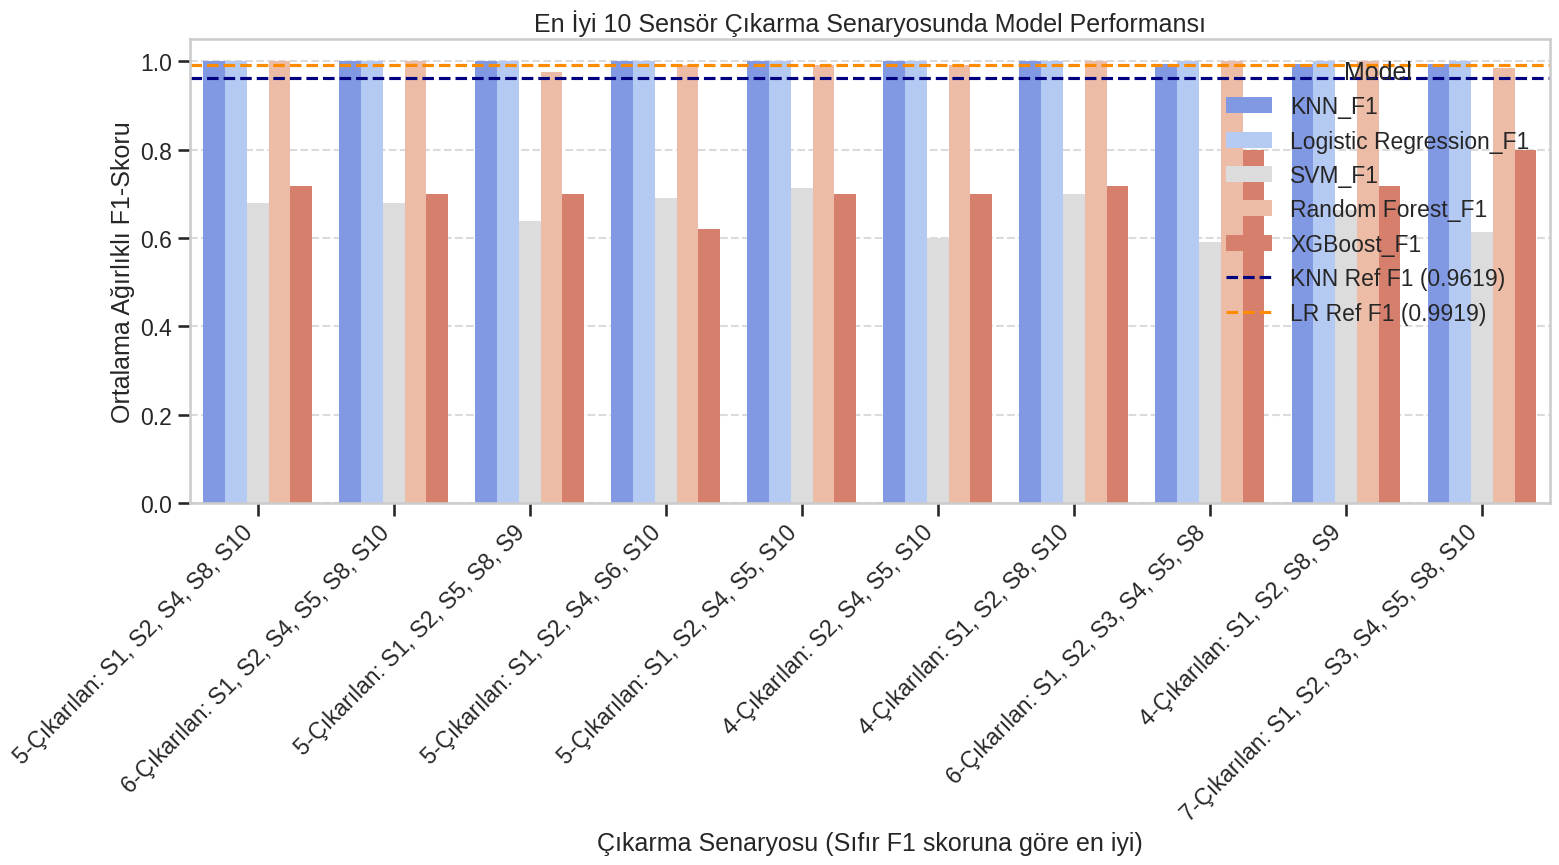



Analiz tamamlandı. En iyi performansı koruyan veya artıran kombinasyonlar belirlendi.


In [14]:
import pandas as pd
import numpy as np
import itertools
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import LabelEncoder, StandardScaler
import time # Süre takibi için

# --- 1. SABİT TANIMLAMALAR ---
# features_df_new_norm'un bu yeni egzersiz verilerini içerdiği varsayılır.

# Orijinal Veri Kümesi Özellikleri ve Etiketleri
X_base = features_df_new_norm.drop(['label', 'user'], axis=1)
y_str_base = features_df_new_norm['label']
groups_base = features_df_new_norm['user']

le = LabelEncoder().fit(y_str_base)
y_base = le.transform(y_str_base)
logo = LeaveOneGroupOut()

# Modelleri tanımla (Sadece en iyi 3 veya 4 modeli seçerek süreyi kısaltabiliriz)
MODELS = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel='rbf', probability=True, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="mlogloss", random_state=42)
}

# Analiz edilecek tüm sensörler
ALL_SENSORS_KEYS = ['s1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10']
# Bağıl özellikler (Rel) özel olarak ele alınacaktır.
REL_FEATURES = [col for col in X_base.columns if col.startswith('rel_')]

# --- 2. DENEME SENARYOLARINI OLUŞTURMA ---

test_scenarios = []

# Başlangıç Senaryosu (Tüm Sensörler, Referans Değer)
test_scenarios.append({
    "Scenario": "0-REFERANS (Tümü)",
    "Sensors_Removed": "Hiçbiri",
    "Columns_Removed": []
})

# Bağıl (Rel) Özellikleri Çıkarma
test_scenarios.append({
    "Scenario": "1-Çıkarılan: REL (Bağıl Özellikler)",
    "Sensors_Removed": "REL",
    "Columns_Removed": REL_FEATURES
})

# Kombinasyon Senaryolarını Oluşturma
# Sadece çıkarma gruplarına odaklanıyoruz (1'li'den 5'li'ye)
for group_size in range(1, 10): # 1'den 5'e kadar grup büyüklükleri
    
    # Tüm olası kombinasyonları al
    all_combinations = list(itertools.combinations(ALL_SENSORS_KEYS, group_size))
    
    # Çok fazla kombinasyon varsa, maksimum 50 tanesini rastgele seç
    max_samples = 200000
    if len(all_combinations) > max_samples:
        selected_combinations = random.sample(all_combinations, max_samples)
    else:
        selected_combinations = all_combinations

    for group in selected_combinations:
        group_str = ", ".join(group).upper()
        
        # Çıkarılacak sütunları oluştur
        cols_to_remove = []
        for sensor_key in group:
            cols_to_remove.extend([col for col in X_base.columns if col.startswith(f'{sensor_key}_')])
        
        test_scenarios.append({
            "Scenario": f"{group_size}-Çıkarılan: {group_str}",
            "Sensors_Removed": group_str,
            "Columns_Removed": cols_to_remove
        })

# --- 3. LOGO CV FONKSİYONU ---

def run_logo_cv(X_df, y_arr, groups_arr, models):
    """Verilen X, y ve gruplar üzerinde LOGO CV uygulayarak F1 skorlarını döndürür."""
    results = {name: [] for name in models.keys()}
    
    # Orijinal kodunuzdaki gibi LOGO CV uygulamasını koruyoruz.
    for train_idx, test_idx in logo.split(X_df, y_arr, groups_arr):
        X_train, X_test = X_df.iloc[train_idx], X_df.iloc[test_idx]
        y_train, y_test = y_arr[train_idx], y_arr[test_idx]
        
        # Standardizasyon
        scaler = StandardScaler().fit(X_train)
        X_train_scaled, X_test_scaled = scaler.transform(X_train), scaler.transform(X_test)

        for name, model in models.items():
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_test_scaled)
            f1 = f1_score(y_test, y_pred, average="weighted")
            results[name].append(f1)
            
    # Ortalama F1 skorlarını hesapla
    avg_f1_scores = {name: np.mean(scores) for name, scores in results.items()}
    return avg_f1_scores

# --- 4. ANALİZİN BAŞLATILMASI ---

analysis_results = []
total_scenarios = len(test_scenarios)

print(f"Toplam {total_scenarios} farklı sensör çıkarma senaryosu test edilecek (Her model için {len(groups_base)} katlama). Bu süreç zaman alabilir.")
print("-" * 80)

start_time = time.time()

for idx, scenario in enumerate(test_scenarios):
    scenario_name = scenario["Scenario"]
    cols_to_drop = scenario["Columns_Removed"]
    
    # Yeni X_df oluştur
    X_current = X_base.drop(cols_to_drop, axis=1, errors='ignore')
    
    # Senaryo ilerlemesini takip et
    print(f"[{idx + 1}/{total_scenarios}] Deneniyor: {scenario_name} | Kalan Özellik Sayısı: {X_current.shape[1]}")
    
    # LOGO CV çalıştır ve F1 skorlarını al
    f1_scores = run_logo_cv(X_current, y_base, groups_base, MODELS)
    
    # Sonuçları kaydet
    result_row = {
        "Senaryo": scenario_name,
        "Çıkarılan Sensörler": scenario["Sensors_Removed"],
        "Kalan Özellik Sayısı": X_current.shape[1],
        **{f"{k}_F1": v for k, v in f1_scores.items()}
    }
    analysis_results.append(result_row)
    
end_time = time.time()
print("-" * 80)
print(f"Tüm analiz {end_time - start_time:.2f} saniyede tamamlandı.")

# --- 5. SONUÇLARIN ÖZETLENMESİ VE GÖRSELLEŞTİRİLMESİ ---

summary_df = pd.DataFrame(analysis_results)

# Referans skorları al
reference_row = summary_df[summary_df['Senaryo'] == '0-REFERANS (Tümü)'].iloc[0]

# Performans Değişimini Hesapla
for model_name in MODELS.keys():
    f1_col = f"{model_name}_F1"
    ref_f1 = reference_row[f1_col]
    
    # Yüzdelik değişim
    summary_df[f"{model_name}_Change (%)"] = ((summary_df[f1_col] - ref_f1) / ref_f1) * 100
    
    # Değişim yüzdesini görselleştirmek için 2 ondalık hane formatı
    summary_df[f"{model_name}_Change (%)"] = summary_df[f"{model_name}_Change (%)"].map('{:.2f}%'.format)

# Sütunları düzenle
final_columns = ["Senaryo", "Çıkarılan Sensörler", "Kalan Özellik Sayısı"] + \
                [col for col in summary_df.columns if col.endswith('_F1')] + \
                [col for col in summary_df.columns if col.endswith('Change (%)')]

# Sonuçları F1 skoruna göre sırala (Örn: En iyi genelleyici olan KNN F1 skoruna göre)
final_summary = summary_df[final_columns].sort_values(by="KNN_F1", ascending=False).reset_index(drop=True)

print("\n\n############################################################")
print("## 🚀 KAPSAMLI SENSÖR ÇIKARMA ANALİZİ SONUÇLARI (Genişletilmiş) ##")
print("############################################################\n")
print(final_summary.to_string())

# --- Sonuçların Görselleştirilmesi (Top 10 En İyi Senaryo) ---

# Sadece F1 skoru en yüksek 10 senaryoyu al (Referans hariç)
top_n = 10
top_scenarios = final_summary.drop(0).head(top_n).copy() 

# Grafiğe uygun formata dönüştür
plot_data_melt = top_scenarios.melt(id_vars='Senaryo', 
                                    value_vars=[f"{m}_F1" for m in MODELS.keys()],
                                    var_name='Model', 
                                    value_name='Average F1-Score')

plt.figure(figsize=(16, 9))
sns.barplot(x='Senaryo', y='Average F1-Score', hue='Model', data=plot_data_melt, palette="coolwarm")
plt.axhline(y=reference_row['KNN_F1'], color='navy', linestyle='--', label=f"KNN Ref F1 ({reference_row['KNN_F1']:.4f})")
plt.axhline(y=reference_row['Logistic Regression_F1'], color='darkorange', linestyle='--', label=f"LR Ref F1 ({reference_row['Logistic Regression_F1']:.4f})")
plt.title(f'En İyi {top_n} Sensör Çıkarma Senaryosunda Model Performansı', fontsize=18)
plt.ylabel('Ortalama Ağırlıklı F1-Skoru')
plt.xlabel('Çıkarma Senaryosu (Sıfır F1 skoruna göre en iyi)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Model', loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\n\nAnaliz tamamlandı. En iyi performansı koruyan veya artıran kombinasyonlar belirlendi.")